[View in Colaboratory](https://colab.research.google.com/github/123miles/AdaptiveSystems_project/blob/master/GAN_example.ipynb)

In [1]:
!pip install torchvision
!pip install tensorboardX
!pip install pillow

In [0]:
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

In [0]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch
from torch.autograd.variable import Variable


'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        var_class = torch.autograd.Variable
        if type(d_error)==var_class:
            d_error = d_error.data.cpu().numpy()
        if type(g_error)==var_class:
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)

        if format=='NHWC':
            images = images.transpose(1,3)


        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):

        var_class = torch.autograd.Variable
        if type(d_error)==var_class:
            d_error = d_error.data.cpu().numpy()[0]
        if type(g_error)==var_class:
            g_error = g_error.data.cpu().numpy()[0]
        if type(d_pred_real)==var_class:
            d_pred_real = d_pred_real.data
        if type(d_pred_fake)==var_class:
            d_pred_fake = d_pred_fake.data


        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise


In [0]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [0]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

# Load data
data = mnist_data()

# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [0]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

discriminator = DiscriminatorNet()

In [0]:
 def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [0]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

generator = GeneratorNet()

In [0]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

In [0]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [0]:
loss = nn.BCELoss()

In [0]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [0]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [0]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)

    # Reset gradients
    optimizer.zero_grad()

    # Sample noise and generate fake data
    prediction = discriminator(fake_data)

    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()

    # Update weights with gradients
    optimizer.step()

    # Return error
    return error

In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples)

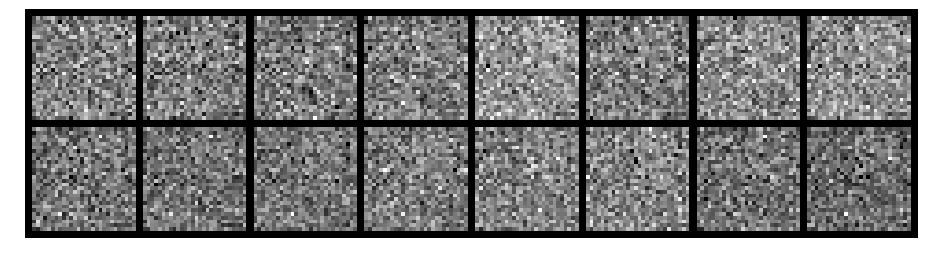

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.4063, Generator Loss: 0.6807
D(x): 0.4962, D(G(z)): 0.5060


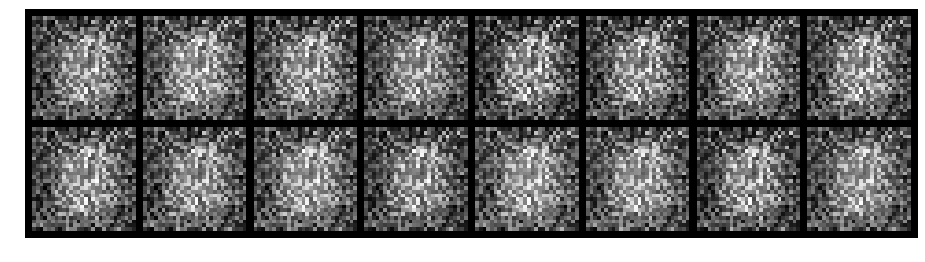

Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 2.3362, Generator Loss: 0.1214
D(x): 0.9215, D(G(z)): 0.8866


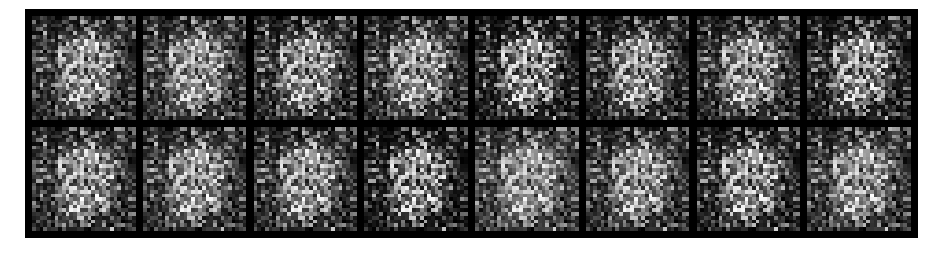

Epoch: [0/200], Batch Num: [200/600]
Discriminator Loss: 0.4271, Generator Loss: 2.4246
D(x): 0.9000, D(G(z)): 0.2644


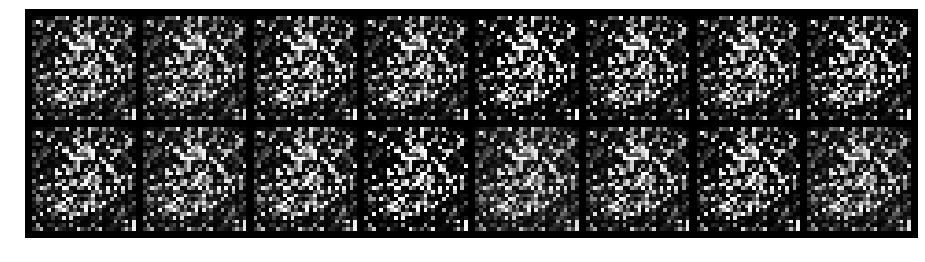

Epoch: [0/200], Batch Num: [300/600]
Discriminator Loss: 1.6955, Generator Loss: 4.2725
D(x): 0.6325, D(G(z)): 0.5831


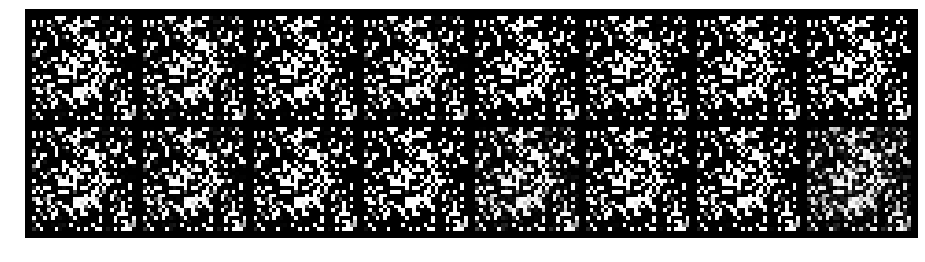

Epoch: [0/200], Batch Num: [400/600]
Discriminator Loss: 0.0308, Generator Loss: 8.3668
D(x): 0.9725, D(G(z)): 0.0027


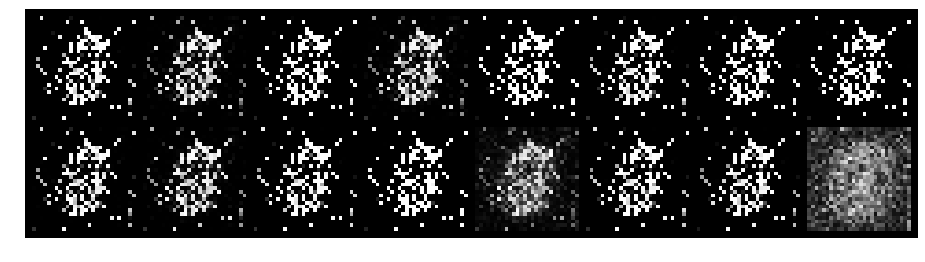

Epoch: [0/200], Batch Num: [500/600]
Discriminator Loss: 0.1883, Generator Loss: 5.3036
D(x): 0.8977, D(G(z)): 0.0540


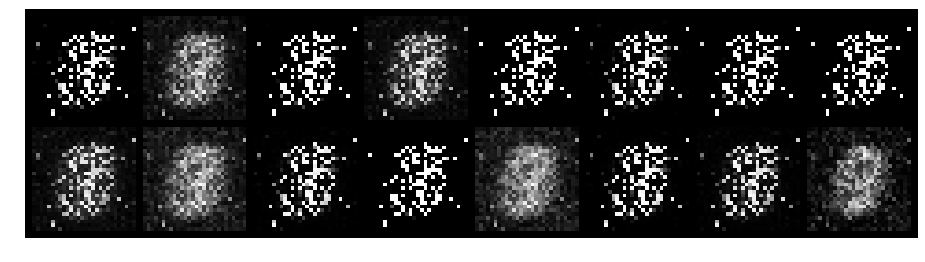

Epoch: [1/200], Batch Num: [0/600]
Discriminator Loss: 0.3330, Generator Loss: 10.0835
D(x): 0.8994, D(G(z)): 0.0995


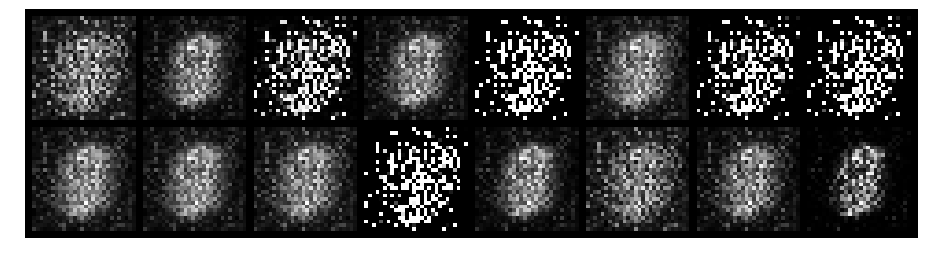

Epoch: [1/200], Batch Num: [100/600]
Discriminator Loss: 0.6881, Generator Loss: 8.0160
D(x): 0.7997, D(G(z)): 0.2504


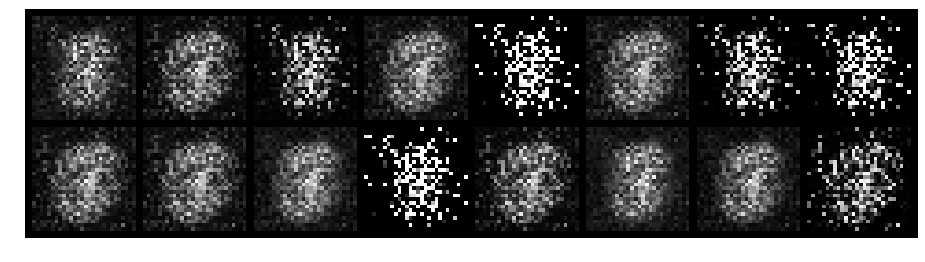

Epoch: [1/200], Batch Num: [200/600]
Discriminator Loss: 1.2416, Generator Loss: 2.3561
D(x): 0.7085, D(G(z)): 0.4801


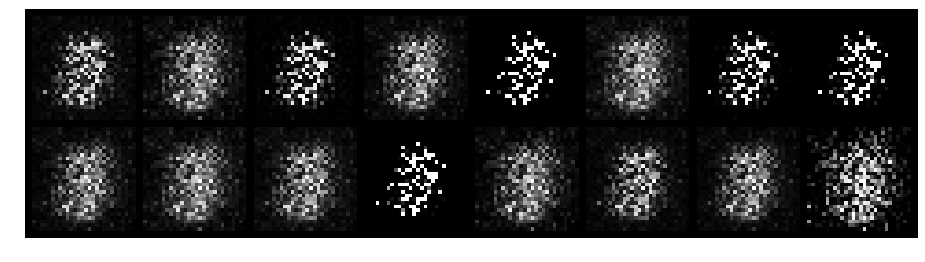

Epoch: [1/200], Batch Num: [300/600]
Discriminator Loss: 0.8807, Generator Loss: 6.3874
D(x): 0.7543, D(G(z)): 0.2035


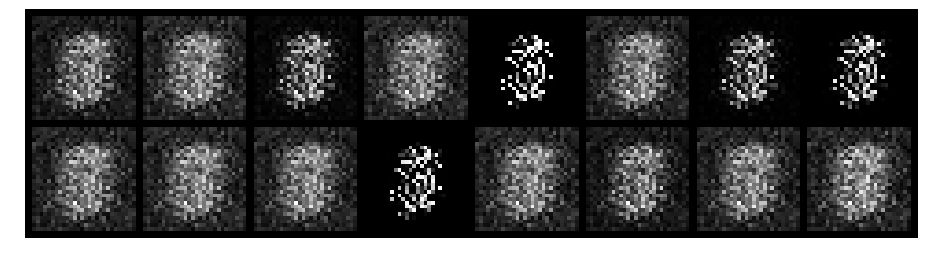

Epoch: [1/200], Batch Num: [400/600]
Discriminator Loss: 1.1941, Generator Loss: 3.3436
D(x): 0.8554, D(G(z)): 0.4141


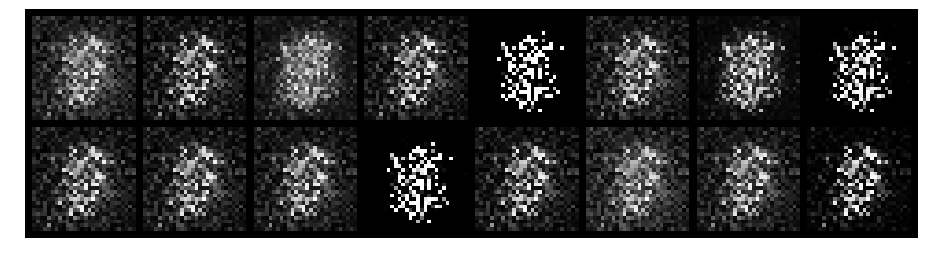

Epoch: [1/200], Batch Num: [500/600]
Discriminator Loss: 1.3293, Generator Loss: 1.0319
D(x): 0.6178, D(G(z)): 0.4762


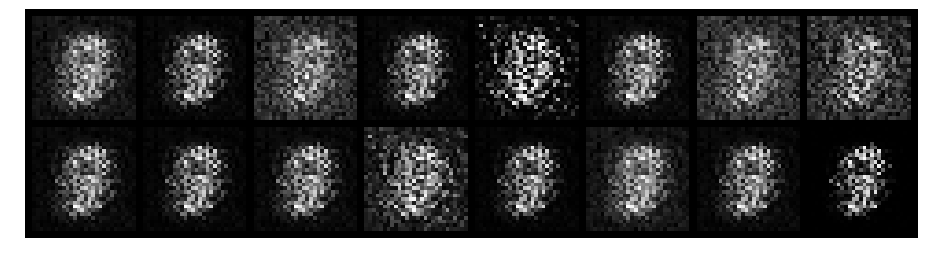

Epoch: [2/200], Batch Num: [0/600]
Discriminator Loss: 1.3251, Generator Loss: 1.8914
D(x): 0.6190, D(G(z)): 0.4262


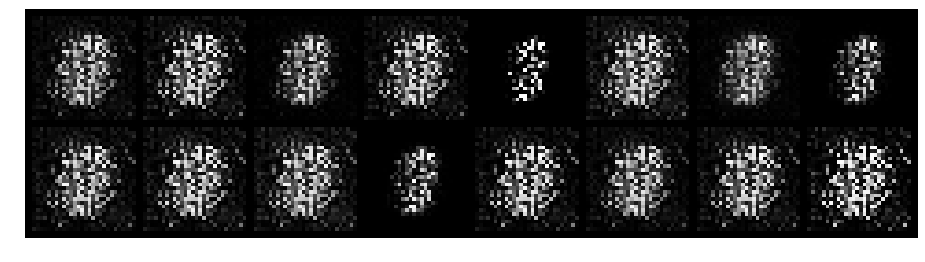

Epoch: [2/200], Batch Num: [100/600]
Discriminator Loss: 0.6348, Generator Loss: 2.7633
D(x): 0.7962, D(G(z)): 0.2120


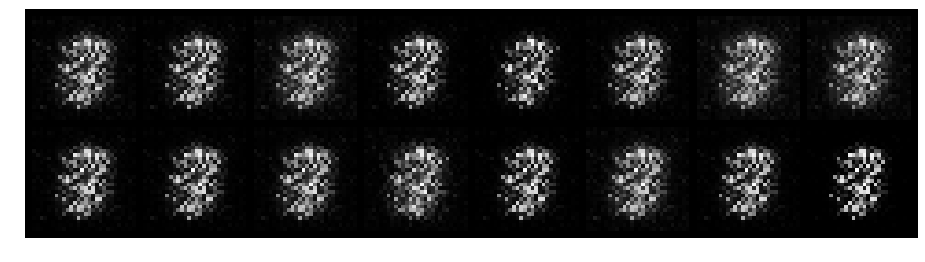

Epoch: [2/200], Batch Num: [200/600]
Discriminator Loss: 0.3742, Generator Loss: 4.0201
D(x): 0.8388, D(G(z)): 0.0887


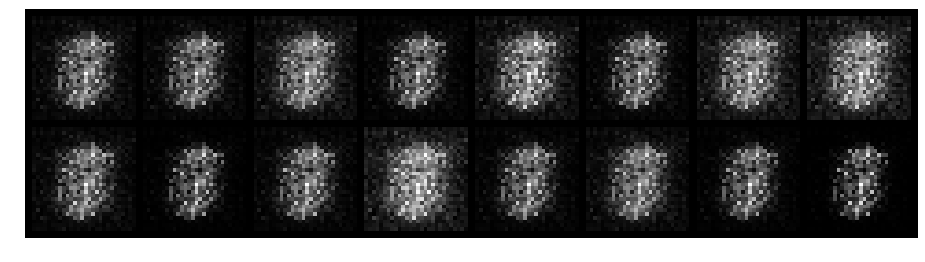

Epoch: [2/200], Batch Num: [300/600]
Discriminator Loss: 1.1782, Generator Loss: 3.0032
D(x): 0.7313, D(G(z)): 0.3018


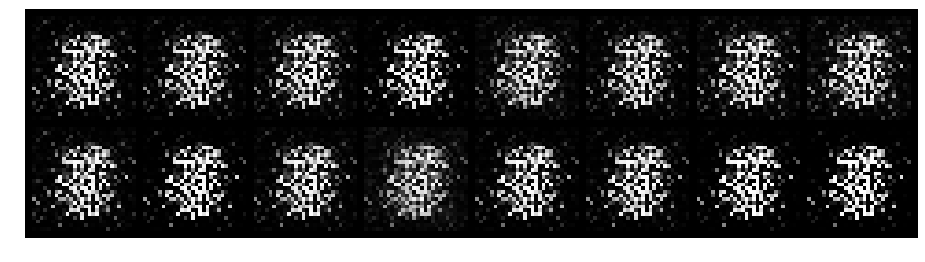

Epoch: [2/200], Batch Num: [400/600]
Discriminator Loss: 0.1578, Generator Loss: 7.9624
D(x): 0.9255, D(G(z)): 0.0562


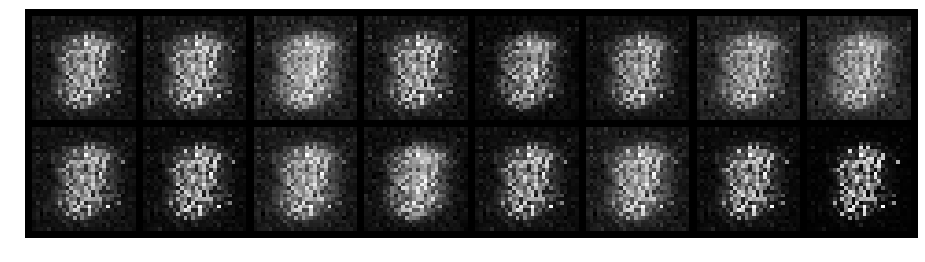

Epoch: [2/200], Batch Num: [500/600]
Discriminator Loss: 0.5209, Generator Loss: 2.2634
D(x): 0.8538, D(G(z)): 0.2184


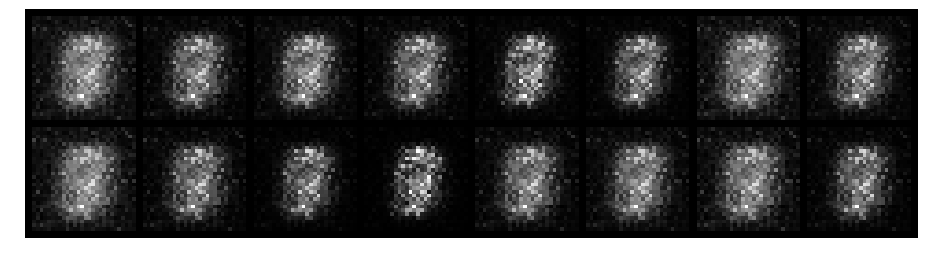

Epoch: [3/200], Batch Num: [0/600]
Discriminator Loss: 2.2713, Generator Loss: 1.9562
D(x): 0.7584, D(G(z)): 0.7066


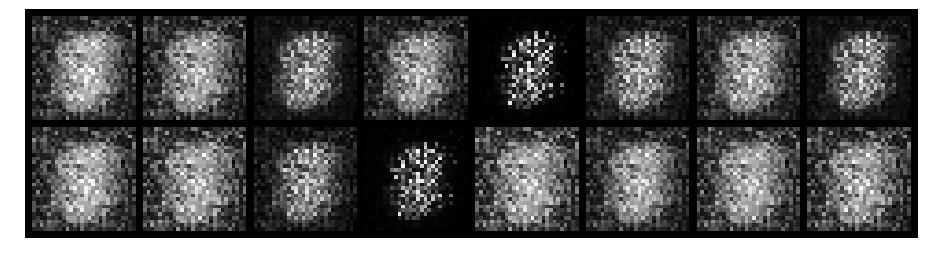

Epoch: [3/200], Batch Num: [100/600]
Discriminator Loss: 0.9529, Generator Loss: 1.4979
D(x): 0.7578, D(G(z)): 0.3708


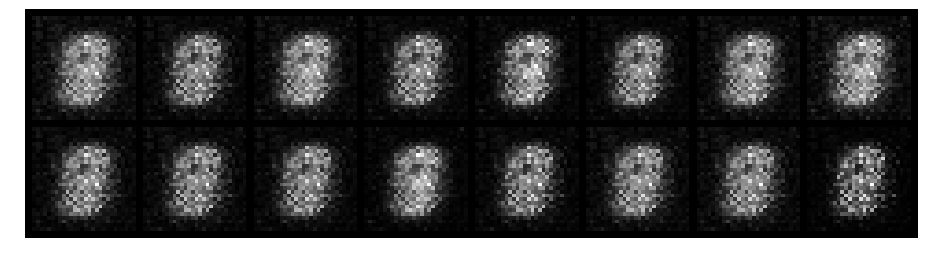

Epoch: [3/200], Batch Num: [200/600]
Discriminator Loss: 0.9012, Generator Loss: 2.0148
D(x): 0.7756, D(G(z)): 0.3484


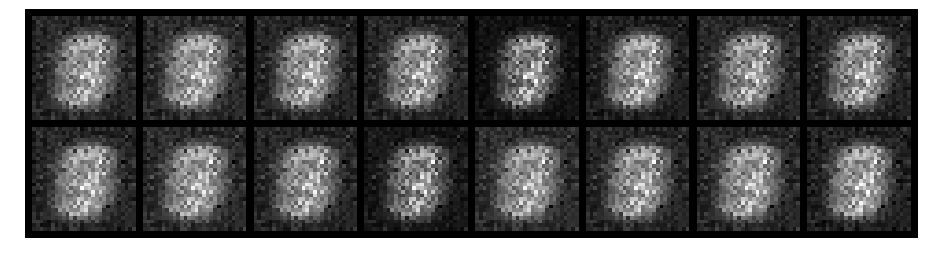

Epoch: [3/200], Batch Num: [300/600]
Discriminator Loss: 0.4457, Generator Loss: 3.0305
D(x): 0.8717, D(G(z)): 0.1686


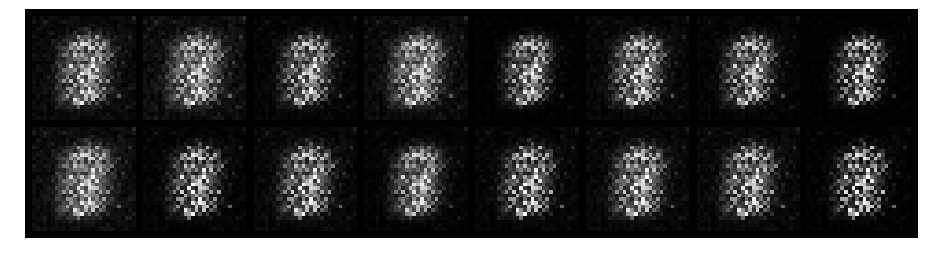

Epoch: [3/200], Batch Num: [400/600]
Discriminator Loss: 0.3711, Generator Loss: 5.3404
D(x): 0.8604, D(G(z)): 0.1143


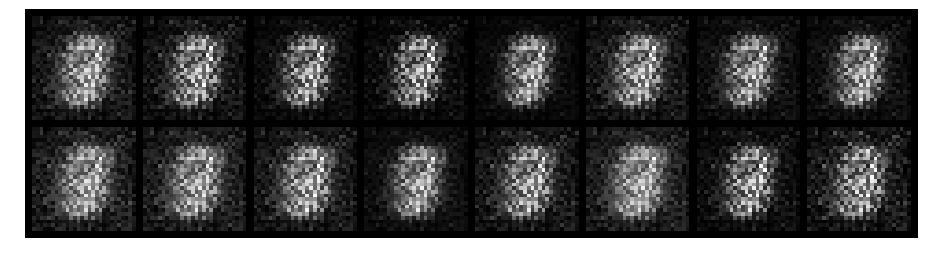

Epoch: [3/200], Batch Num: [500/600]
Discriminator Loss: 0.5492, Generator Loss: 2.9716
D(x): 0.8061, D(G(z)): 0.1419


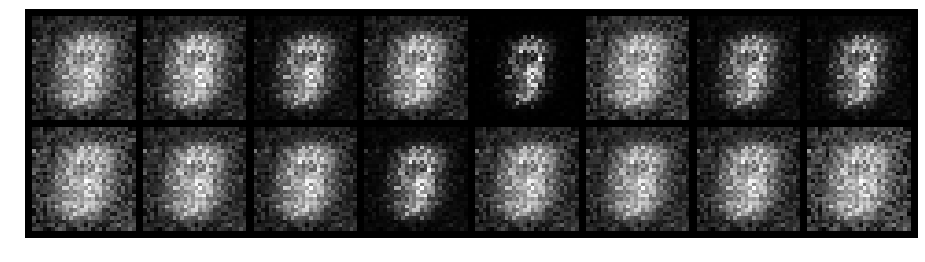

Epoch: [4/200], Batch Num: [0/600]
Discriminator Loss: 0.8433, Generator Loss: 1.3751
D(x): 0.7945, D(G(z)): 0.2697


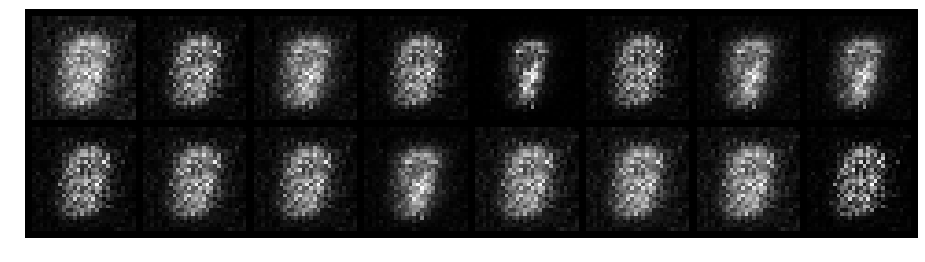

Epoch: [4/200], Batch Num: [100/600]
Discriminator Loss: 0.5403, Generator Loss: 2.5299
D(x): 0.9032, D(G(z)): 0.2166


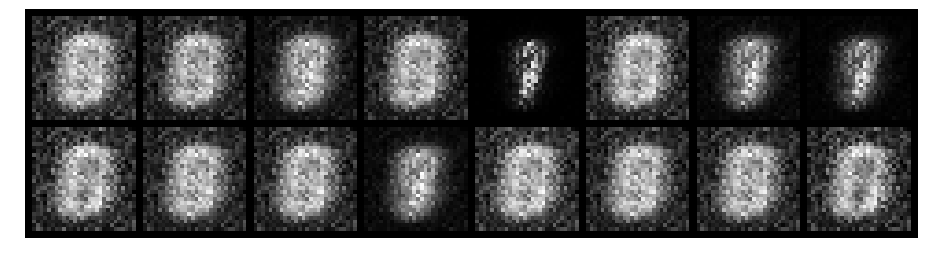

Epoch: [4/200], Batch Num: [200/600]
Discriminator Loss: 0.4229, Generator Loss: 4.1013
D(x): 0.8918, D(G(z)): 0.0953


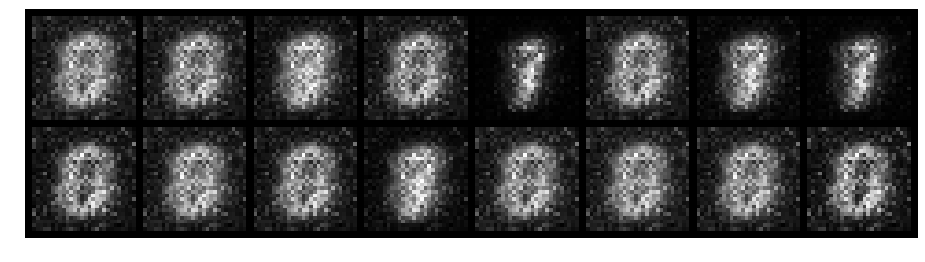

Epoch: [4/200], Batch Num: [300/600]
Discriminator Loss: 0.4061, Generator Loss: 2.0542
D(x): 0.9104, D(G(z)): 0.1916


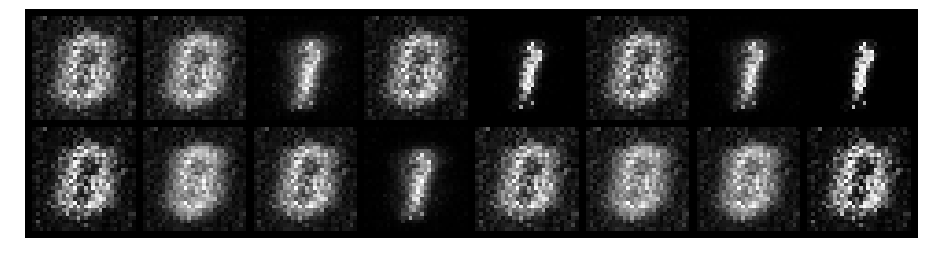

Epoch: [4/200], Batch Num: [400/600]
Discriminator Loss: 0.3105, Generator Loss: 2.8228
D(x): 0.9122, D(G(z)): 0.1296


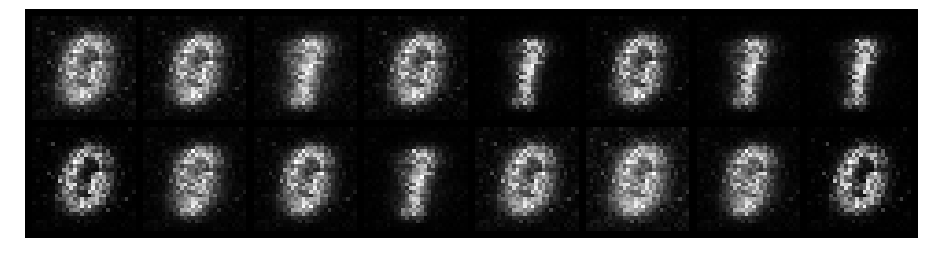

Epoch: [4/200], Batch Num: [500/600]
Discriminator Loss: 0.2209, Generator Loss: 4.1438
D(x): 0.9611, D(G(z)): 0.1186


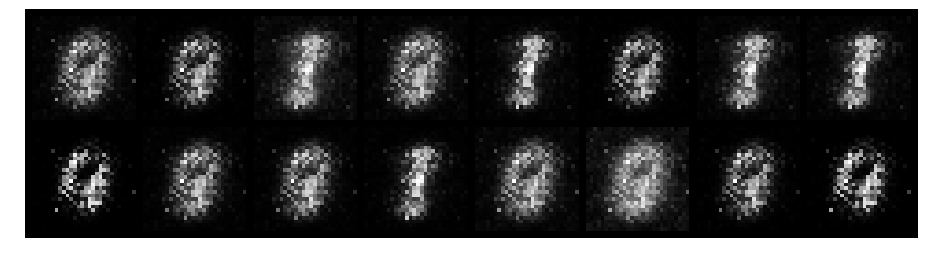

Epoch: [5/200], Batch Num: [0/600]
Discriminator Loss: 0.1961, Generator Loss: 3.7128
D(x): 0.9586, D(G(z)): 0.0920


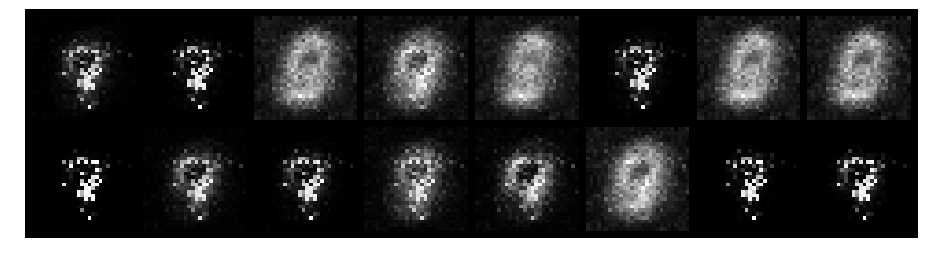

Epoch: [5/200], Batch Num: [100/600]
Discriminator Loss: 0.3178, Generator Loss: 3.7732
D(x): 0.8863, D(G(z)): 0.0737


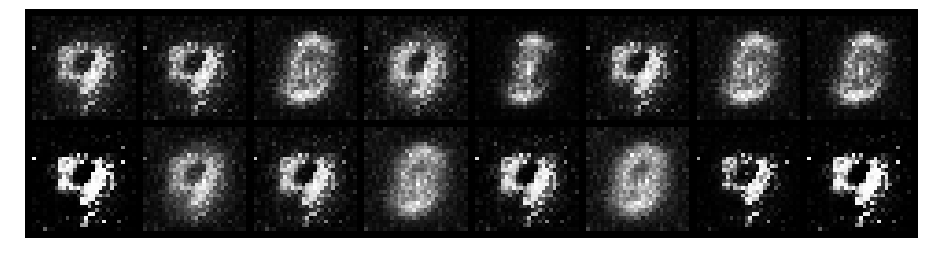

Epoch: [5/200], Batch Num: [200/600]
Discriminator Loss: 0.1664, Generator Loss: 4.5386
D(x): 0.9501, D(G(z)): 0.0763


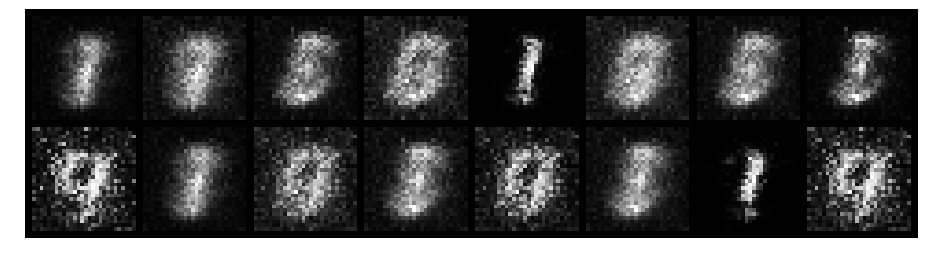

Epoch: [5/200], Batch Num: [300/600]
Discriminator Loss: 0.3770, Generator Loss: 3.1488
D(x): 0.9334, D(G(z)): 0.1694


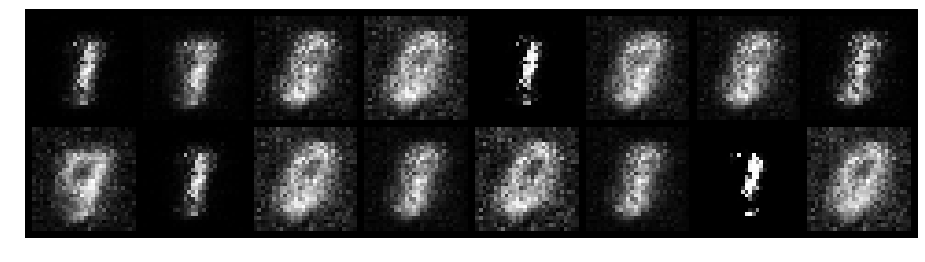

Epoch: [5/200], Batch Num: [400/600]
Discriminator Loss: 0.2918, Generator Loss: 4.0416
D(x): 0.9082, D(G(z)): 0.0667


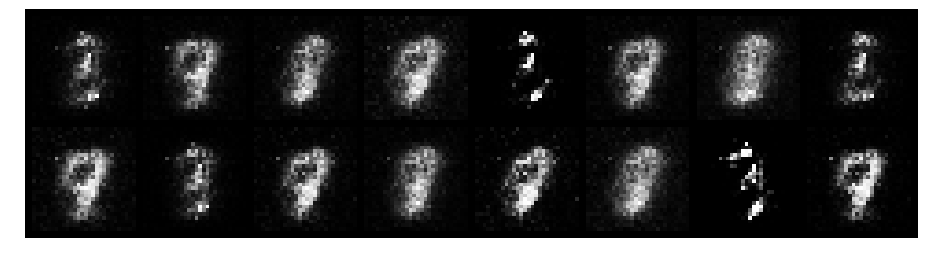

Epoch: [5/200], Batch Num: [500/600]
Discriminator Loss: 0.3455, Generator Loss: 4.4509
D(x): 0.8808, D(G(z)): 0.0907


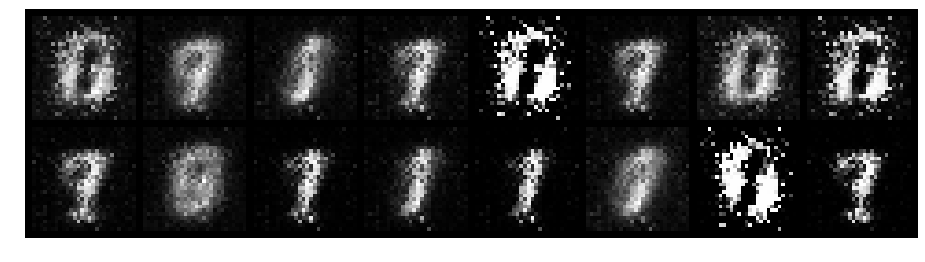

Epoch: [6/200], Batch Num: [0/600]
Discriminator Loss: 0.4328, Generator Loss: 3.5022
D(x): 0.8236, D(G(z)): 0.0907


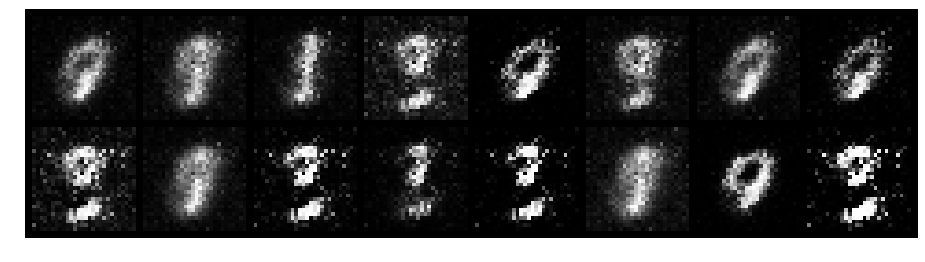

Epoch: [6/200], Batch Num: [100/600]
Discriminator Loss: 0.5702, Generator Loss: 3.5295
D(x): 0.7849, D(G(z)): 0.1231


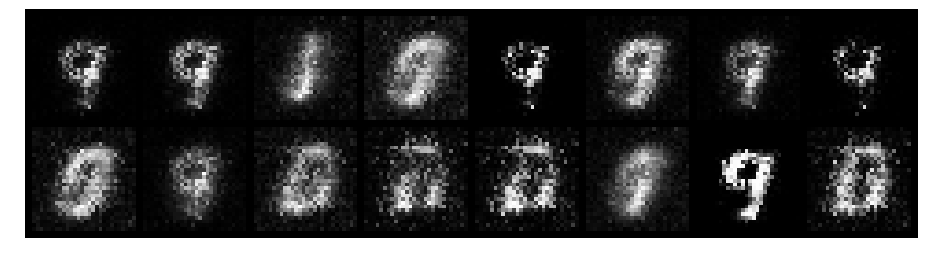

Epoch: [6/200], Batch Num: [200/600]
Discriminator Loss: 0.4862, Generator Loss: 2.4311
D(x): 0.8902, D(G(z)): 0.2031


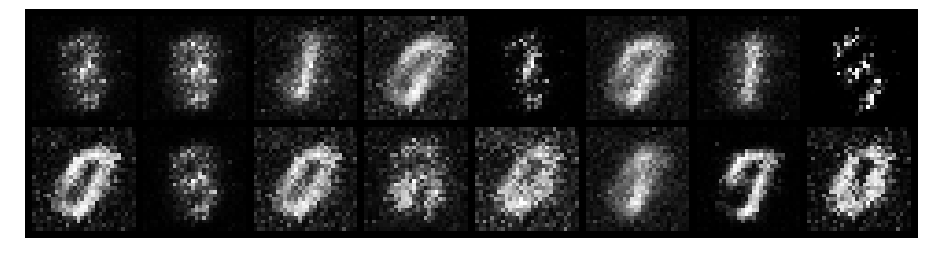

Epoch: [6/200], Batch Num: [300/600]
Discriminator Loss: 0.5703, Generator Loss: 2.6899
D(x): 0.8204, D(G(z)): 0.1298


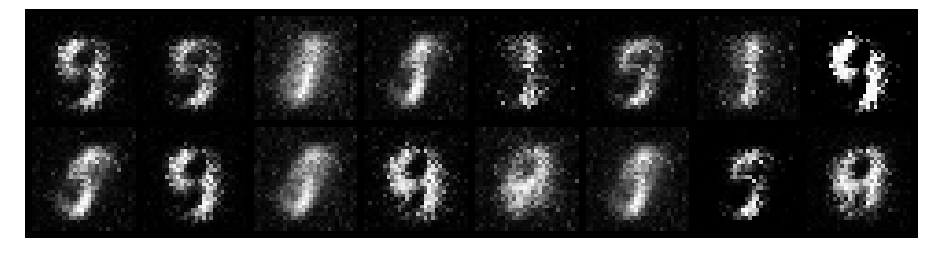

Epoch: [6/200], Batch Num: [400/600]
Discriminator Loss: 0.8202, Generator Loss: 2.2815
D(x): 0.8231, D(G(z)): 0.2698


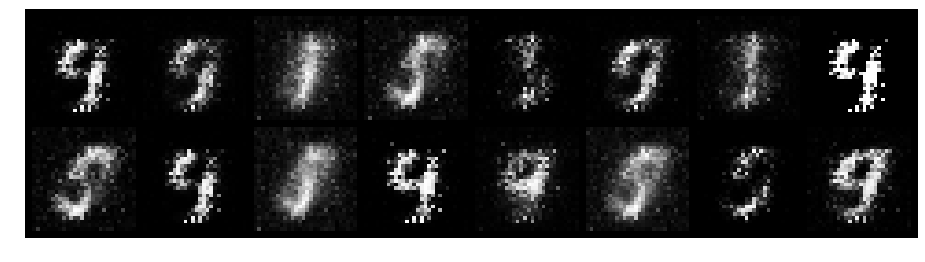

Epoch: [6/200], Batch Num: [500/600]
Discriminator Loss: 0.2207, Generator Loss: 4.1817
D(x): 0.9280, D(G(z)): 0.0546


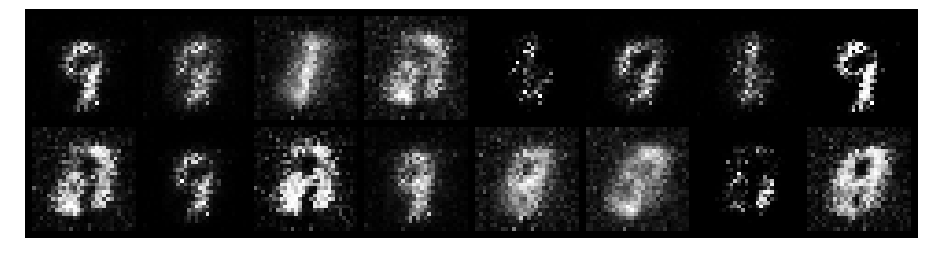

Epoch: [7/200], Batch Num: [0/600]
Discriminator Loss: 0.3459, Generator Loss: 4.0218
D(x): 0.8584, D(G(z)): 0.0793


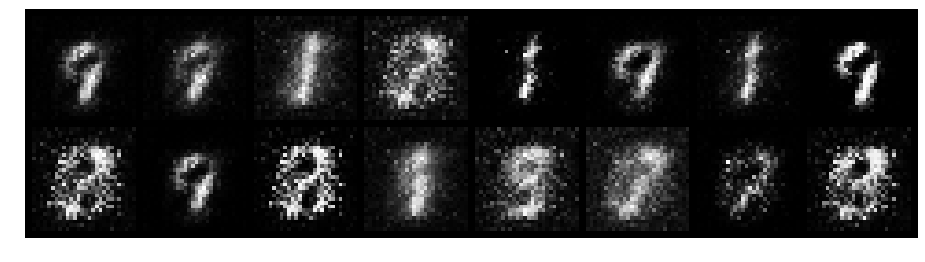

Epoch: [7/200], Batch Num: [100/600]
Discriminator Loss: 0.3283, Generator Loss: 3.3780
D(x): 0.9122, D(G(z)): 0.1327


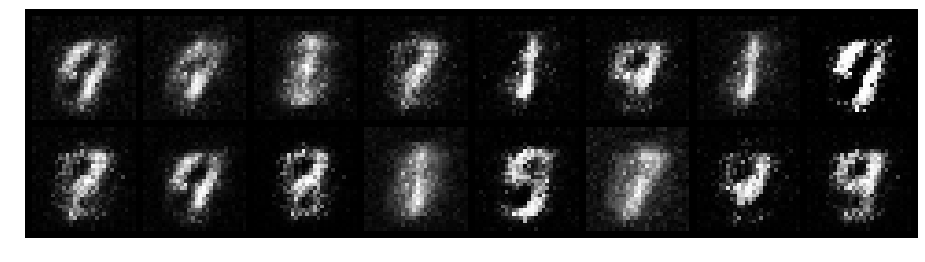

Epoch: [7/200], Batch Num: [200/600]
Discriminator Loss: 0.7068, Generator Loss: 3.1303
D(x): 0.7704, D(G(z)): 0.1201


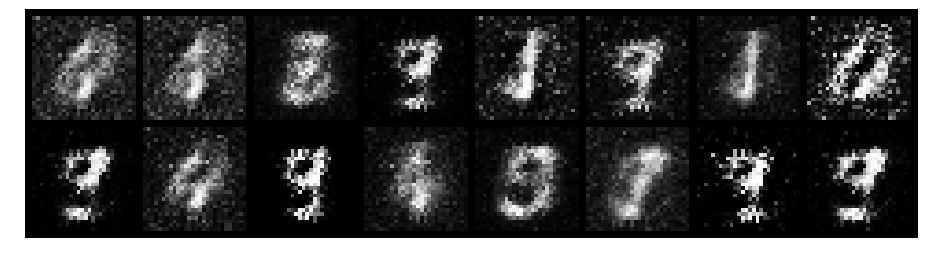

Epoch: [7/200], Batch Num: [300/600]
Discriminator Loss: 0.2336, Generator Loss: 3.5754
D(x): 0.9375, D(G(z)): 0.1093


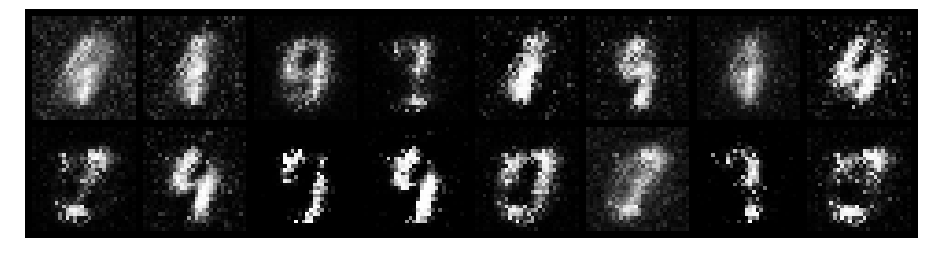

Epoch: [7/200], Batch Num: [400/600]
Discriminator Loss: 0.4979, Generator Loss: 2.5973
D(x): 0.8533, D(G(z)): 0.1786


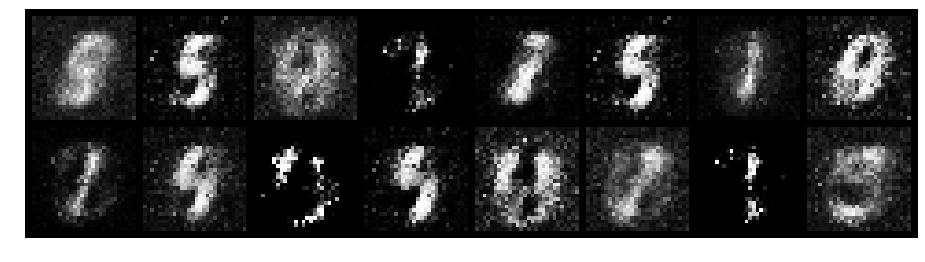

Epoch: [7/200], Batch Num: [500/600]
Discriminator Loss: 0.5689, Generator Loss: 3.1499
D(x): 0.7778, D(G(z)): 0.1106


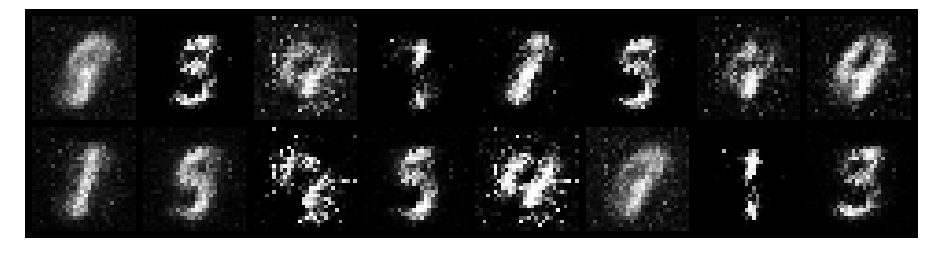

Epoch: [8/200], Batch Num: [0/600]
Discriminator Loss: 0.4327, Generator Loss: 3.7017
D(x): 0.8498, D(G(z)): 0.1149


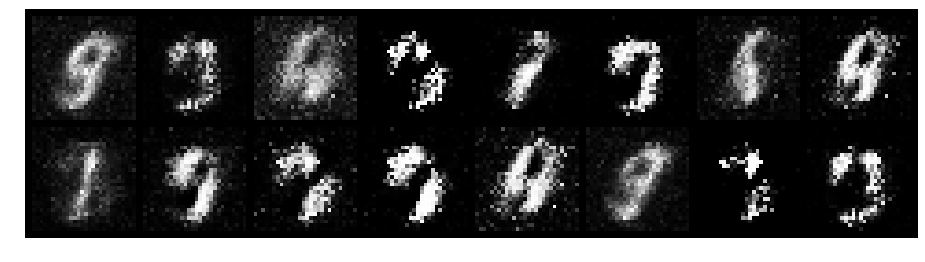

Epoch: [8/200], Batch Num: [100/600]
Discriminator Loss: 0.4775, Generator Loss: 3.5246
D(x): 0.8282, D(G(z)): 0.0904


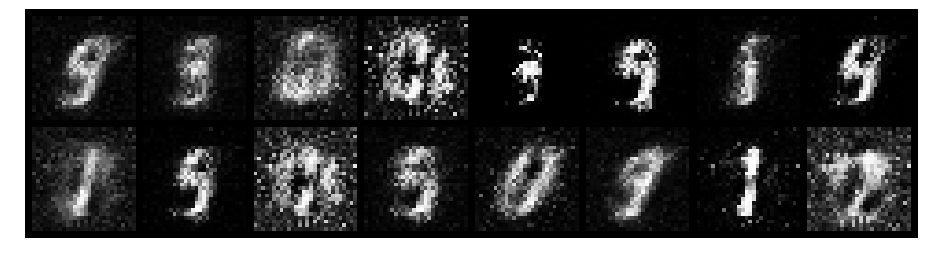

Epoch: [8/200], Batch Num: [200/600]
Discriminator Loss: 0.5469, Generator Loss: 3.3223
D(x): 0.8870, D(G(z)): 0.2288


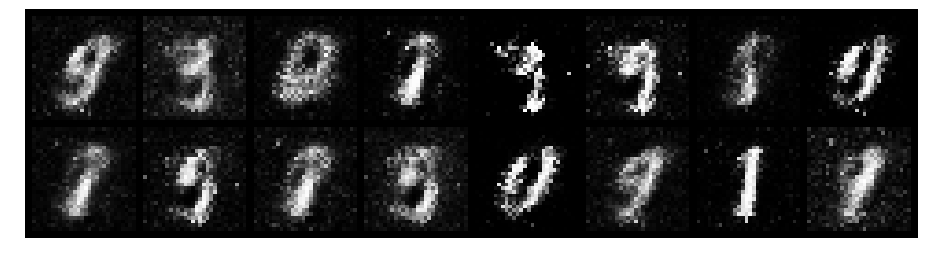

Epoch: [8/200], Batch Num: [300/600]
Discriminator Loss: 0.4497, Generator Loss: 3.2854
D(x): 0.8823, D(G(z)): 0.1309


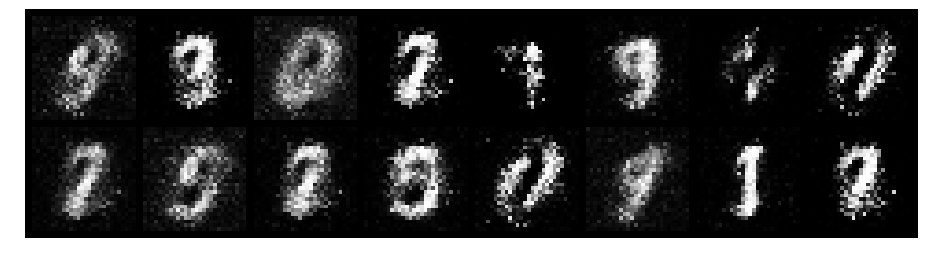

Epoch: [8/200], Batch Num: [400/600]
Discriminator Loss: 0.5773, Generator Loss: 3.4755
D(x): 0.8278, D(G(z)): 0.1783


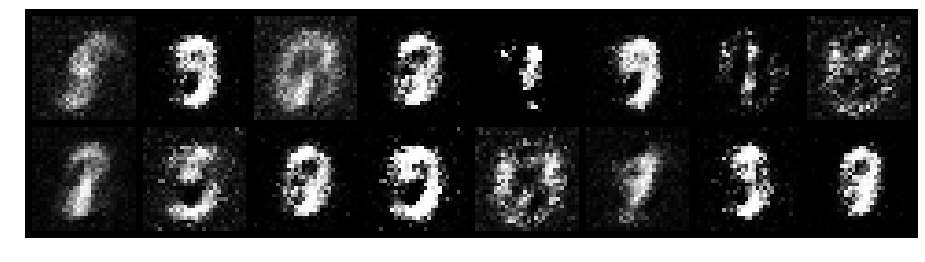

Epoch: [8/200], Batch Num: [500/600]
Discriminator Loss: 0.6993, Generator Loss: 3.0161
D(x): 0.9167, D(G(z)): 0.2714


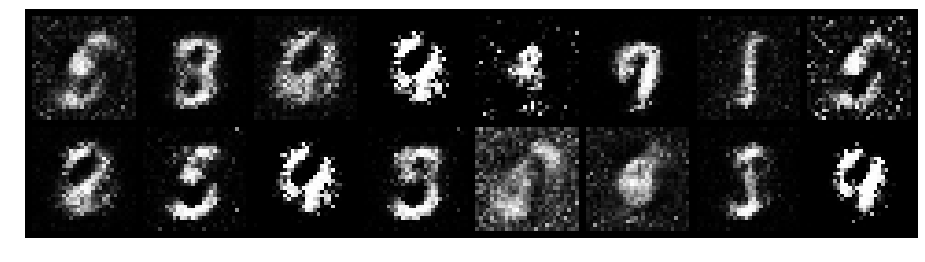

Epoch: [9/200], Batch Num: [0/600]
Discriminator Loss: 0.3555, Generator Loss: 3.0413
D(x): 0.8750, D(G(z)): 0.1283


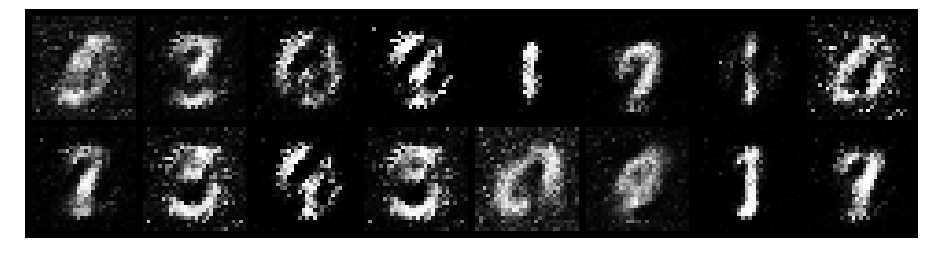

Epoch: [9/200], Batch Num: [100/600]
Discriminator Loss: 0.4637, Generator Loss: 2.7392
D(x): 0.8793, D(G(z)): 0.2017


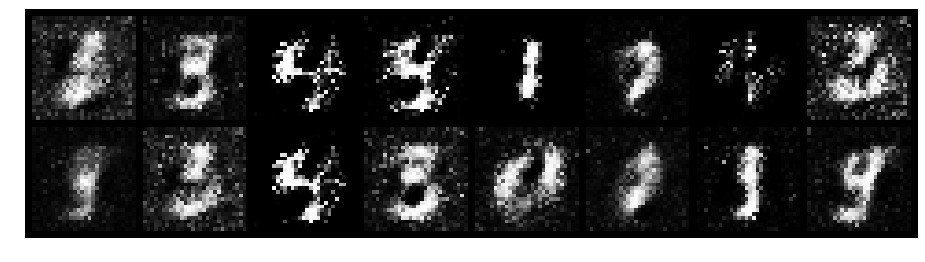

Epoch: [9/200], Batch Num: [200/600]
Discriminator Loss: 0.3783, Generator Loss: 2.9265
D(x): 0.9109, D(G(z)): 0.1853


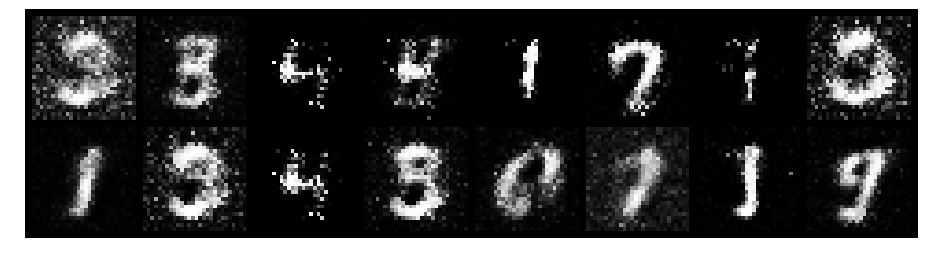

Epoch: [9/200], Batch Num: [300/600]
Discriminator Loss: 0.5336, Generator Loss: 2.4946
D(x): 0.8862, D(G(z)): 0.2419


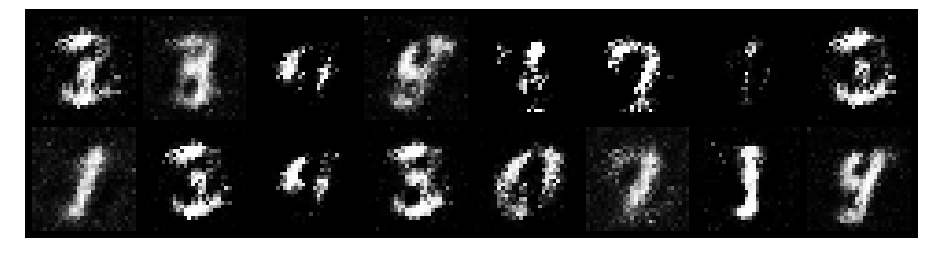

Epoch: [9/200], Batch Num: [400/600]
Discriminator Loss: 0.5443, Generator Loss: 2.1023
D(x): 0.8546, D(G(z)): 0.1911


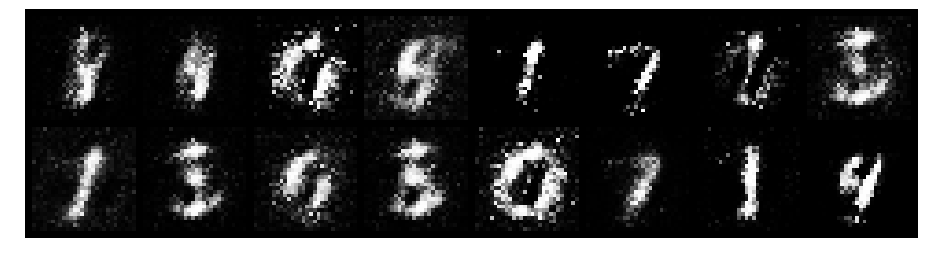

Epoch: [9/200], Batch Num: [500/600]
Discriminator Loss: 0.5932, Generator Loss: 2.2517
D(x): 0.8478, D(G(z)): 0.1970


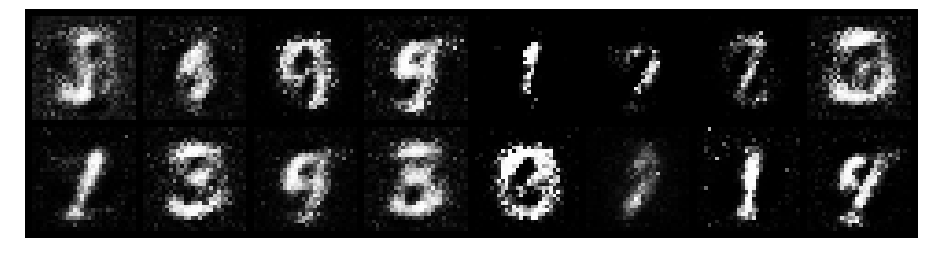

Epoch: [10/200], Batch Num: [0/600]
Discriminator Loss: 0.8690, Generator Loss: 1.6445
D(x): 0.7657, D(G(z)): 0.2450


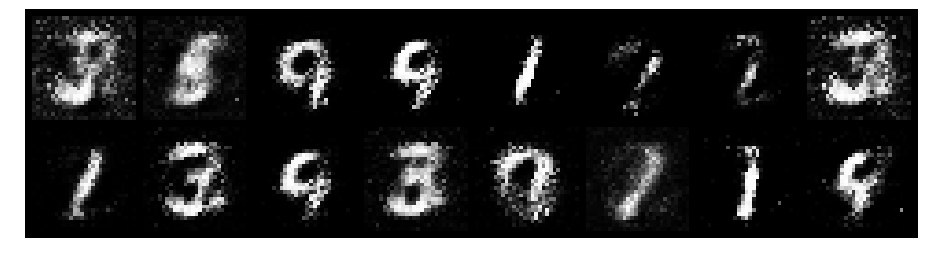

Epoch: [10/200], Batch Num: [100/600]
Discriminator Loss: 0.5718, Generator Loss: 2.5219
D(x): 0.8582, D(G(z)): 0.2135


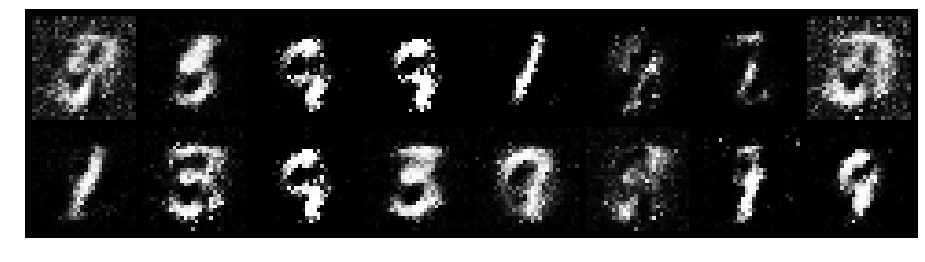

Epoch: [10/200], Batch Num: [200/600]
Discriminator Loss: 0.9518, Generator Loss: 1.9808
D(x): 0.7338, D(G(z)): 0.2739


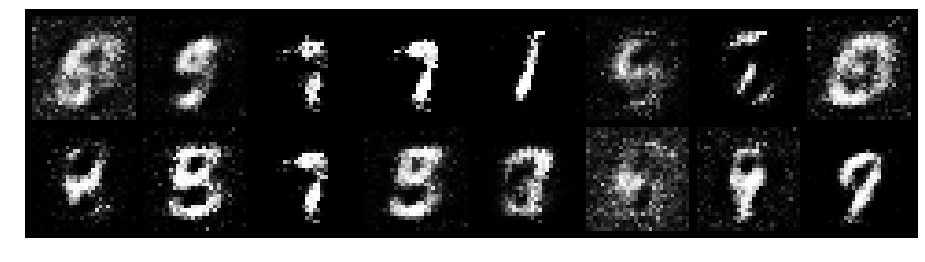

Epoch: [10/200], Batch Num: [300/600]
Discriminator Loss: 0.8246, Generator Loss: 1.6767
D(x): 0.6980, D(G(z)): 0.1953


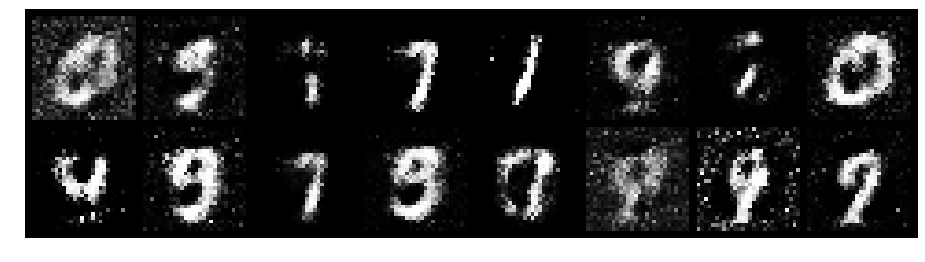

Epoch: [10/200], Batch Num: [400/600]
Discriminator Loss: 0.6383, Generator Loss: 2.5141
D(x): 0.8449, D(G(z)): 0.2203


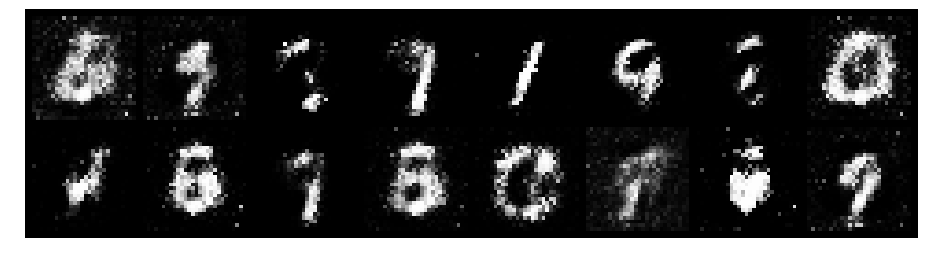

Epoch: [10/200], Batch Num: [500/600]
Discriminator Loss: 0.4454, Generator Loss: 2.6749
D(x): 0.8909, D(G(z)): 0.1789


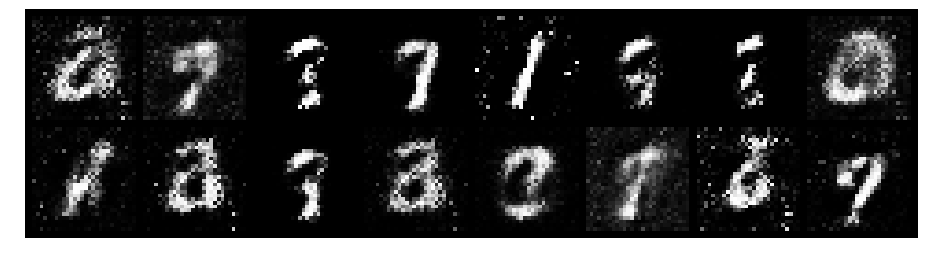

Epoch: [11/200], Batch Num: [0/600]
Discriminator Loss: 0.5262, Generator Loss: 2.1550
D(x): 0.7863, D(G(z)): 0.1674


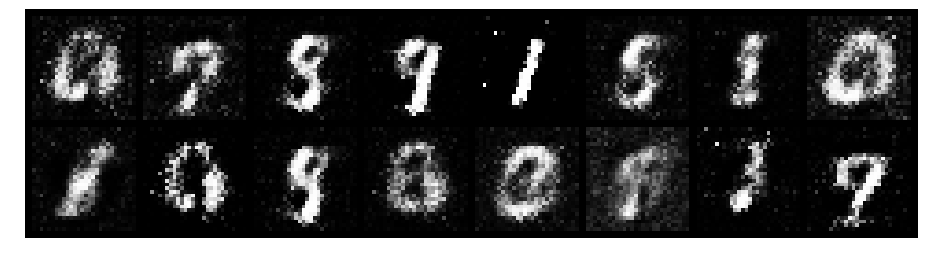

Epoch: [11/200], Batch Num: [100/600]
Discriminator Loss: 0.6122, Generator Loss: 2.6953
D(x): 0.8243, D(G(z)): 0.1840


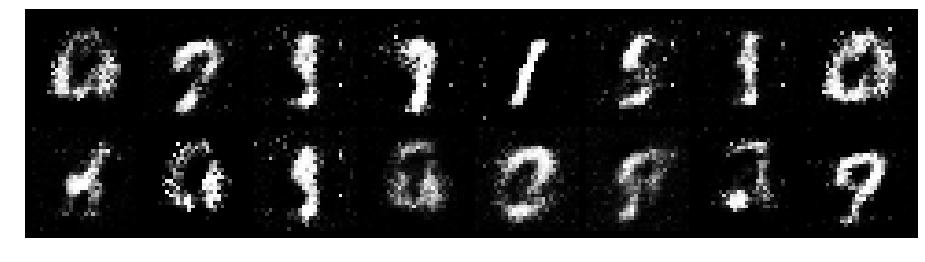

Epoch: [11/200], Batch Num: [200/600]
Discriminator Loss: 0.6734, Generator Loss: 2.1123
D(x): 0.8089, D(G(z)): 0.2460


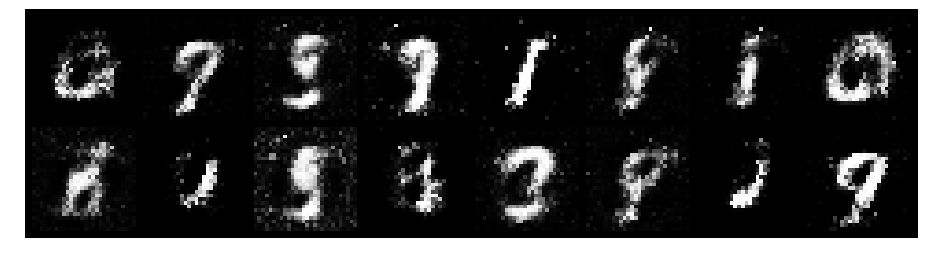

Epoch: [11/200], Batch Num: [300/600]
Discriminator Loss: 0.5521, Generator Loss: 2.5515
D(x): 0.8315, D(G(z)): 0.1658


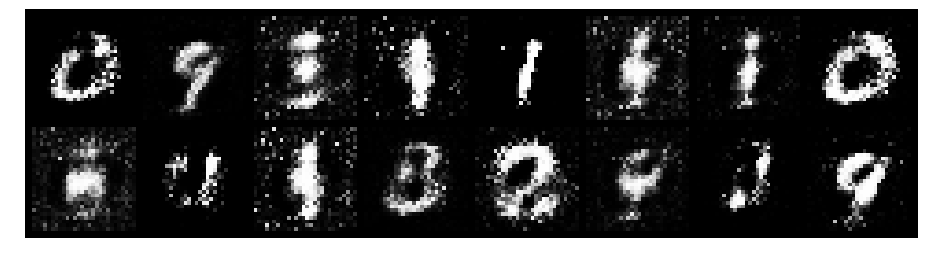

Epoch: [11/200], Batch Num: [400/600]
Discriminator Loss: 0.5263, Generator Loss: 1.9993
D(x): 0.8298, D(G(z)): 0.1936


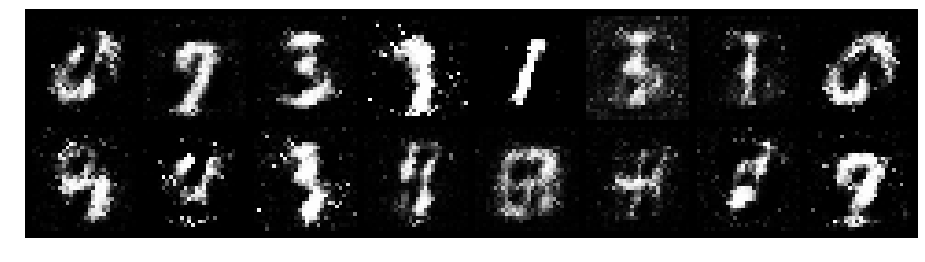

Epoch: [11/200], Batch Num: [500/600]
Discriminator Loss: 1.0983, Generator Loss: 2.2998
D(x): 0.6194, D(G(z)): 0.2251


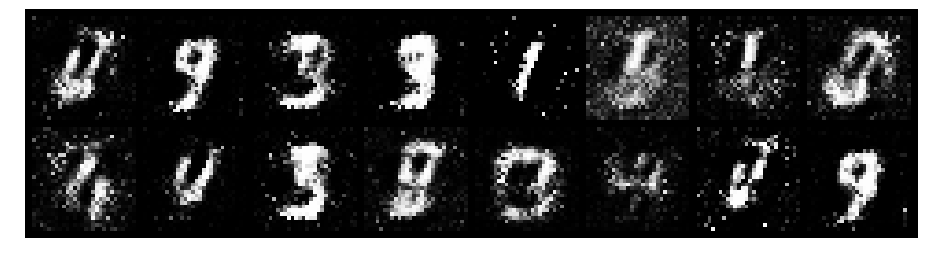

Epoch: [12/200], Batch Num: [0/600]
Discriminator Loss: 0.9079, Generator Loss: 2.1855
D(x): 0.8291, D(G(z)): 0.3886


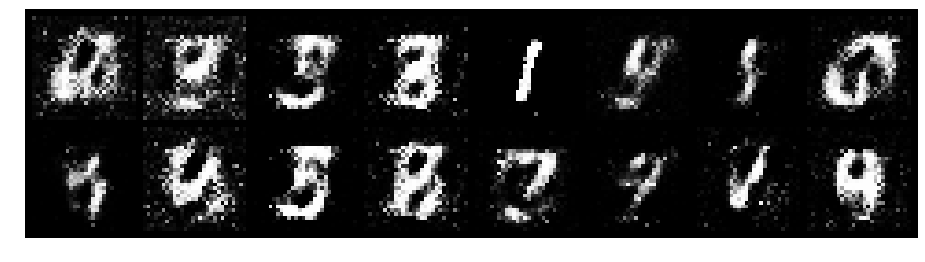

Epoch: [12/200], Batch Num: [100/600]
Discriminator Loss: 0.8227, Generator Loss: 1.6924
D(x): 0.6857, D(G(z)): 0.2064


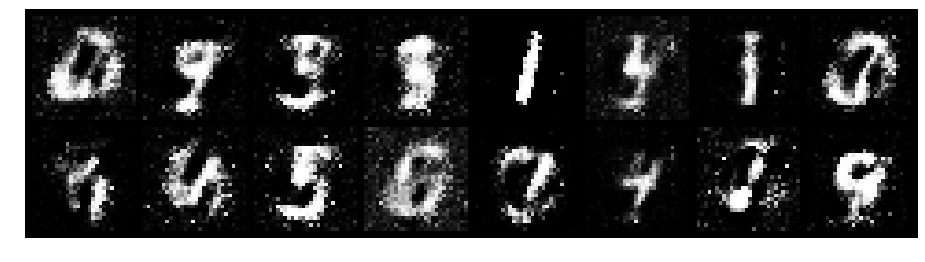

Epoch: [12/200], Batch Num: [200/600]
Discriminator Loss: 0.5853, Generator Loss: 1.8808
D(x): 0.8879, D(G(z)): 0.2808


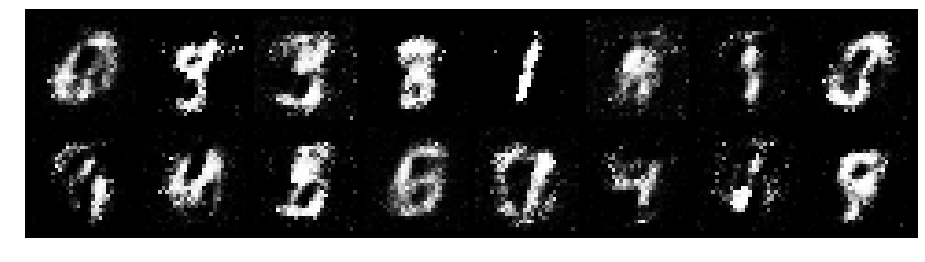

Epoch: [12/200], Batch Num: [300/600]
Discriminator Loss: 0.6758, Generator Loss: 1.8054
D(x): 0.7894, D(G(z)): 0.2153


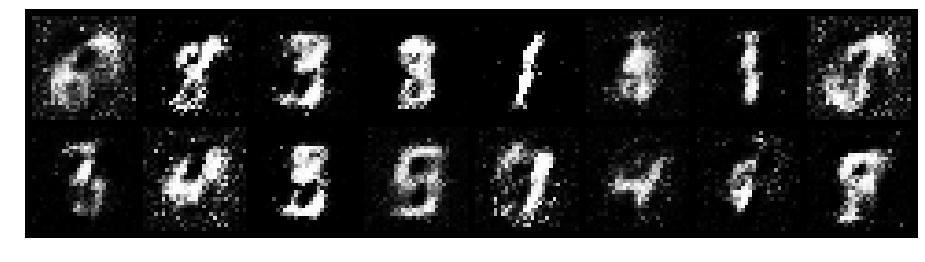

Epoch: [12/200], Batch Num: [400/600]
Discriminator Loss: 0.6877, Generator Loss: 1.8238
D(x): 0.7344, D(G(z)): 0.1847


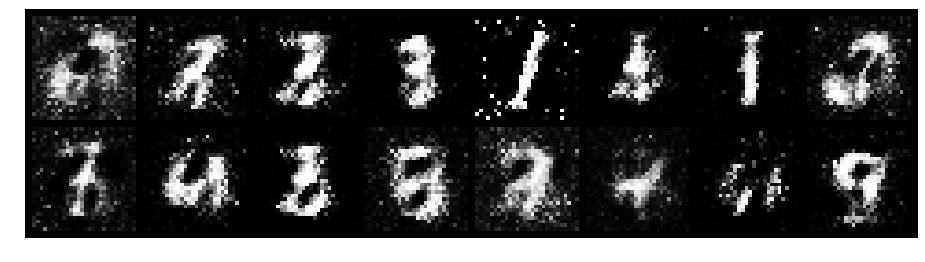

Epoch: [12/200], Batch Num: [500/600]
Discriminator Loss: 0.6244, Generator Loss: 3.0419
D(x): 0.8143, D(G(z)): 0.2259


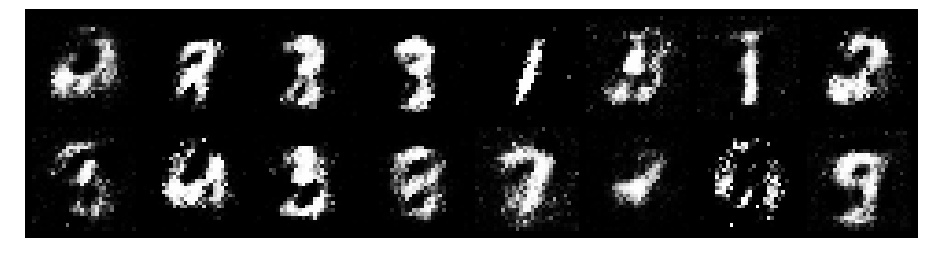

Epoch: [13/200], Batch Num: [0/600]
Discriminator Loss: 0.6911, Generator Loss: 2.0730
D(x): 0.7986, D(G(z)): 0.2371


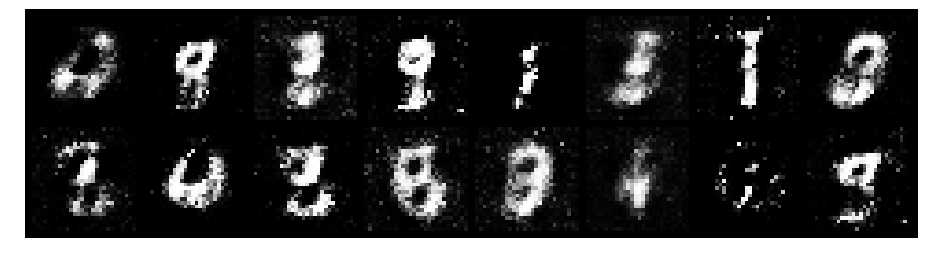

Epoch: [13/200], Batch Num: [100/600]
Discriminator Loss: 0.6072, Generator Loss: 2.4574
D(x): 0.7952, D(G(z)): 0.1908


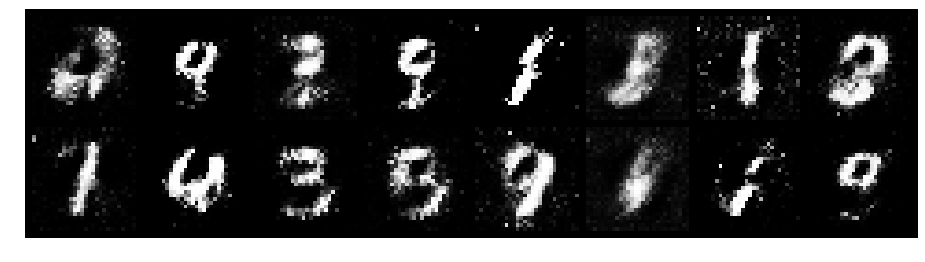

Epoch: [13/200], Batch Num: [200/600]
Discriminator Loss: 0.5526, Generator Loss: 2.3847
D(x): 0.7988, D(G(z)): 0.1565


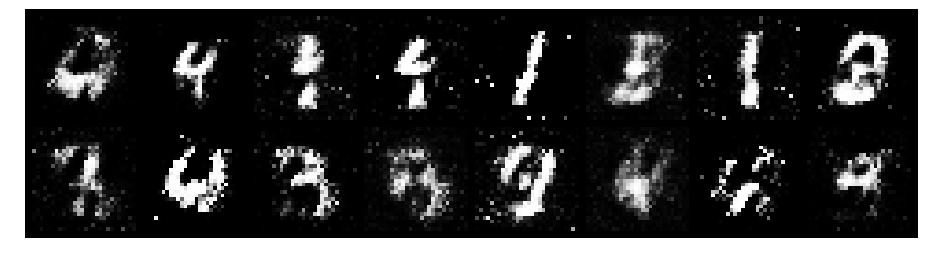

Epoch: [13/200], Batch Num: [300/600]
Discriminator Loss: 1.0275, Generator Loss: 2.2390
D(x): 0.6311, D(G(z)): 0.2148


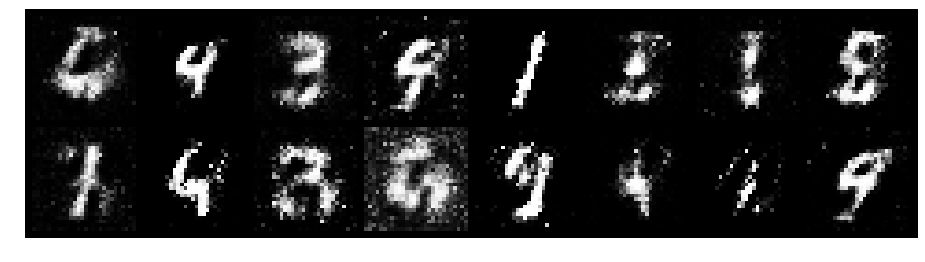

Epoch: [13/200], Batch Num: [400/600]
Discriminator Loss: 0.9314, Generator Loss: 1.8881
D(x): 0.7636, D(G(z)): 0.2848


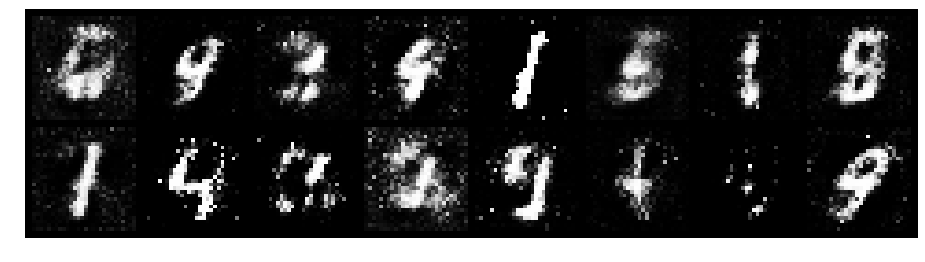

Epoch: [13/200], Batch Num: [500/600]
Discriminator Loss: 0.8330, Generator Loss: 2.0639
D(x): 0.7259, D(G(z)): 0.1973


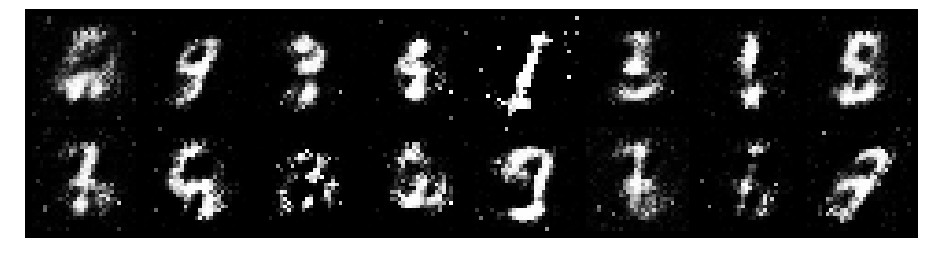

Epoch: [14/200], Batch Num: [0/600]
Discriminator Loss: 0.8366, Generator Loss: 1.4211
D(x): 0.7700, D(G(z)): 0.2983


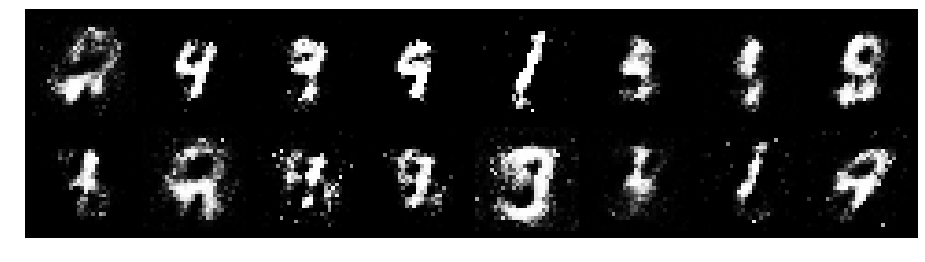

Epoch: [14/200], Batch Num: [100/600]
Discriminator Loss: 0.8274, Generator Loss: 1.6328
D(x): 0.7998, D(G(z)): 0.3194


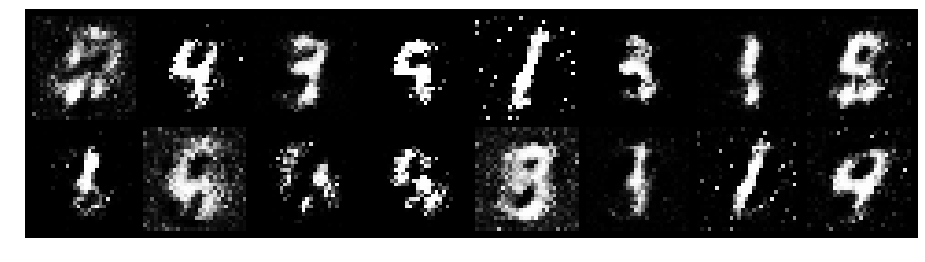

Epoch: [14/200], Batch Num: [200/600]
Discriminator Loss: 0.7026, Generator Loss: 2.2847
D(x): 0.7363, D(G(z)): 0.2091


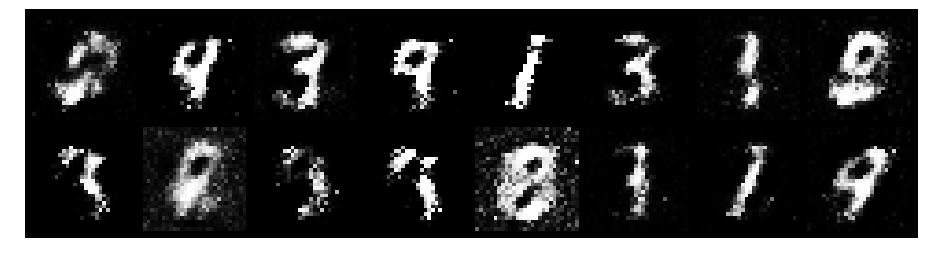

Epoch: [14/200], Batch Num: [300/600]
Discriminator Loss: 0.8599, Generator Loss: 2.0617
D(x): 0.6856, D(G(z)): 0.2091


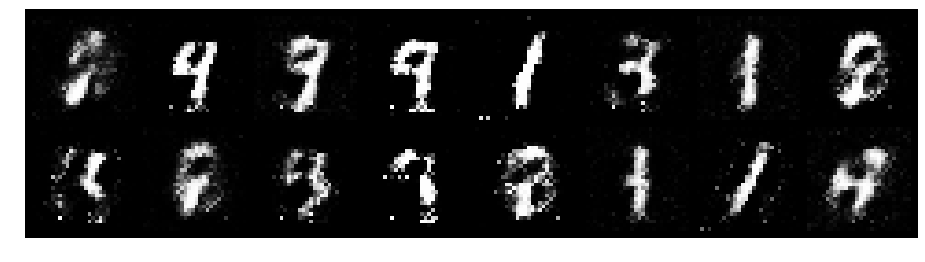

Epoch: [14/200], Batch Num: [400/600]
Discriminator Loss: 0.7214, Generator Loss: 2.6055
D(x): 0.7576, D(G(z)): 0.1744


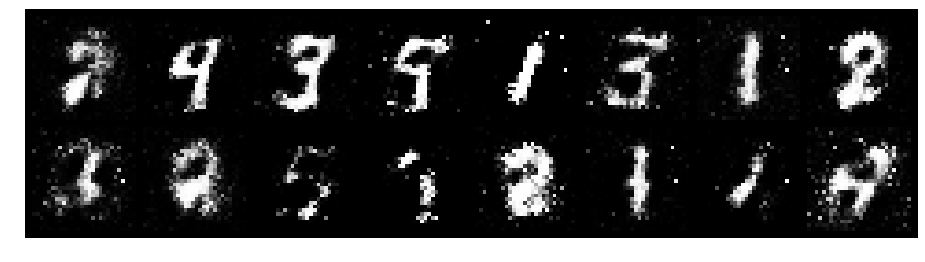

Epoch: [14/200], Batch Num: [500/600]
Discriminator Loss: 0.7683, Generator Loss: 1.9959
D(x): 0.7104, D(G(z)): 0.2364


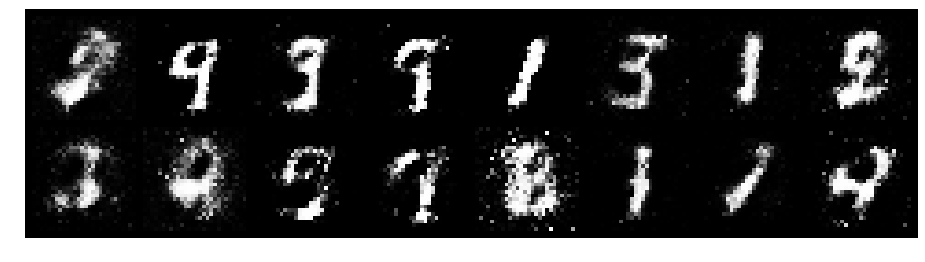

Epoch: [15/200], Batch Num: [0/600]
Discriminator Loss: 0.8993, Generator Loss: 1.4295
D(x): 0.7074, D(G(z)): 0.2911


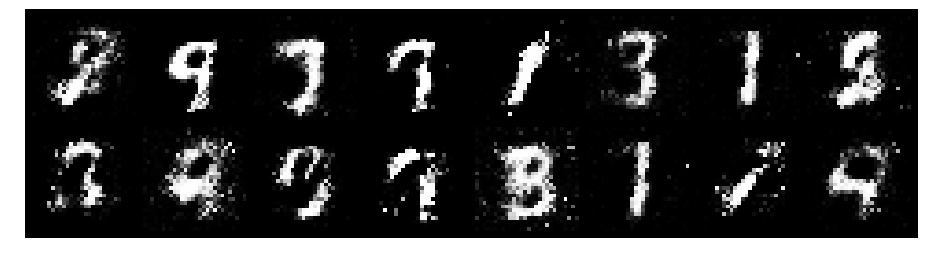

Epoch: [15/200], Batch Num: [100/600]
Discriminator Loss: 0.8388, Generator Loss: 1.6763
D(x): 0.6509, D(G(z)): 0.2160


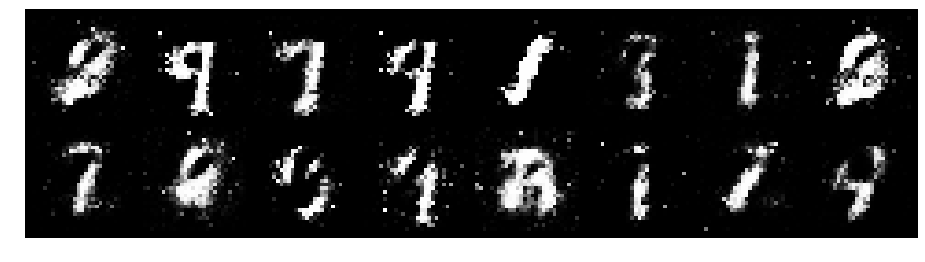

Epoch: [15/200], Batch Num: [200/600]
Discriminator Loss: 1.0421, Generator Loss: 1.1633
D(x): 0.7323, D(G(z)): 0.4004


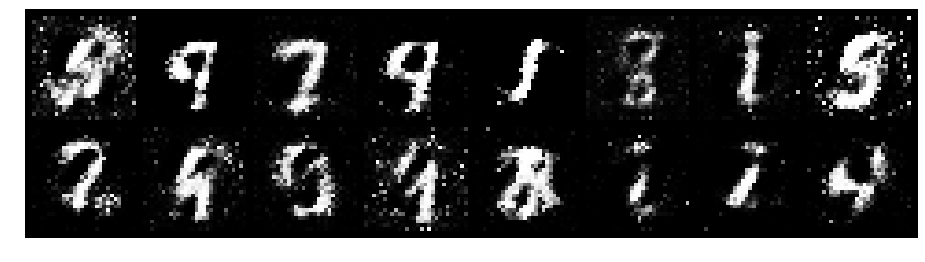

Epoch: [15/200], Batch Num: [300/600]
Discriminator Loss: 1.0234, Generator Loss: 1.6804
D(x): 0.7087, D(G(z)): 0.3089


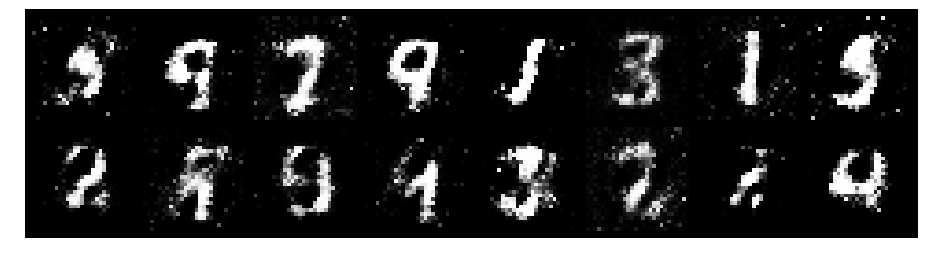

Epoch: [15/200], Batch Num: [400/600]
Discriminator Loss: 0.8439, Generator Loss: 2.1649
D(x): 0.6832, D(G(z)): 0.2045


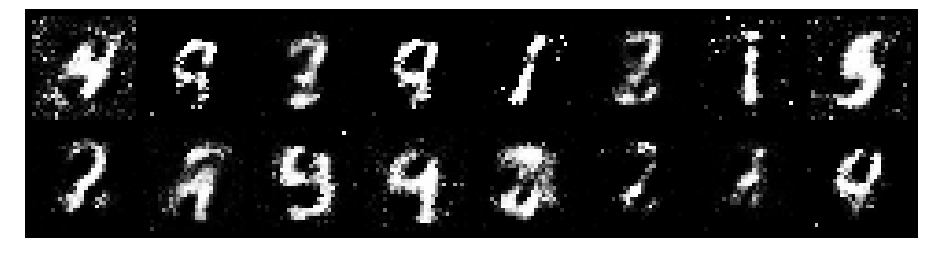

Epoch: [15/200], Batch Num: [500/600]
Discriminator Loss: 0.7904, Generator Loss: 1.8957
D(x): 0.8037, D(G(z)): 0.2864


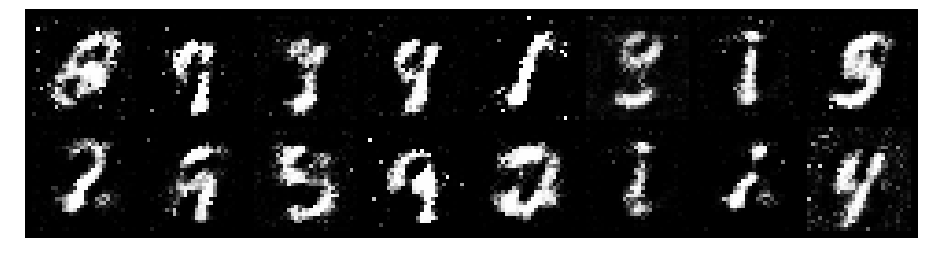

Epoch: [16/200], Batch Num: [0/600]
Discriminator Loss: 1.0250, Generator Loss: 2.2577
D(x): 0.7225, D(G(z)): 0.2848


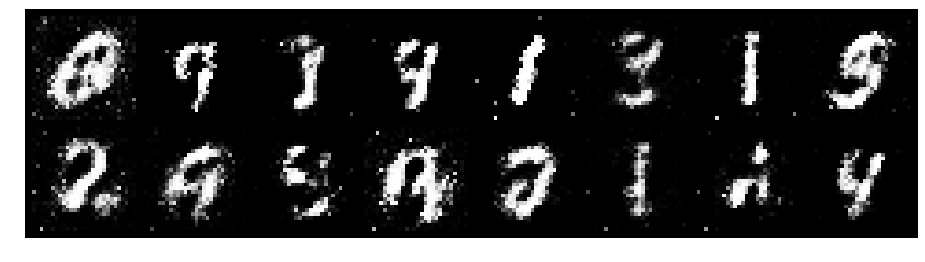

Epoch: [16/200], Batch Num: [100/600]
Discriminator Loss: 0.6770, Generator Loss: 2.2196
D(x): 0.7769, D(G(z)): 0.2247


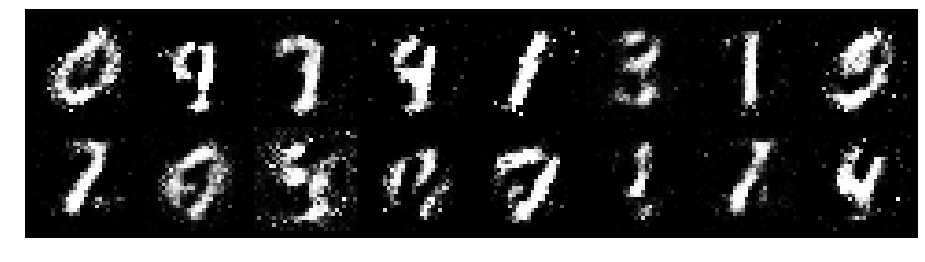

Epoch: [16/200], Batch Num: [200/600]
Discriminator Loss: 0.8089, Generator Loss: 2.2480
D(x): 0.7222, D(G(z)): 0.2405


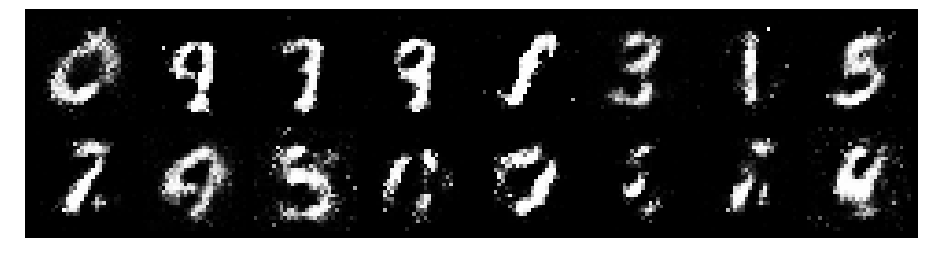

Epoch: [16/200], Batch Num: [300/600]
Discriminator Loss: 0.6726, Generator Loss: 2.2762
D(x): 0.7395, D(G(z)): 0.1768


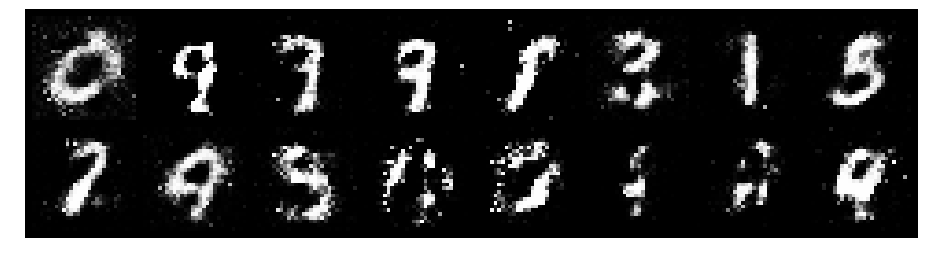

Epoch: [16/200], Batch Num: [400/600]
Discriminator Loss: 0.7365, Generator Loss: 1.6316
D(x): 0.7714, D(G(z)): 0.2834


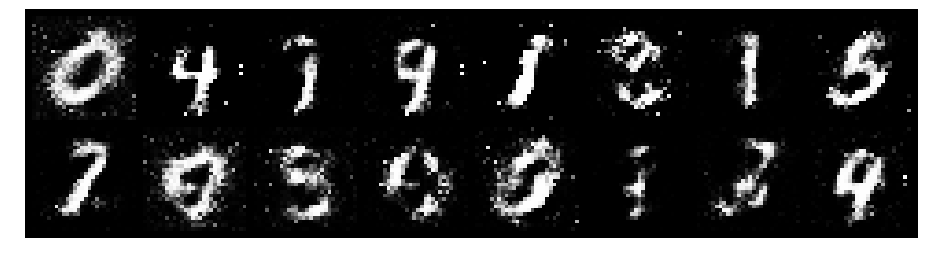

Epoch: [16/200], Batch Num: [500/600]
Discriminator Loss: 0.7271, Generator Loss: 1.7308
D(x): 0.8110, D(G(z)): 0.3096


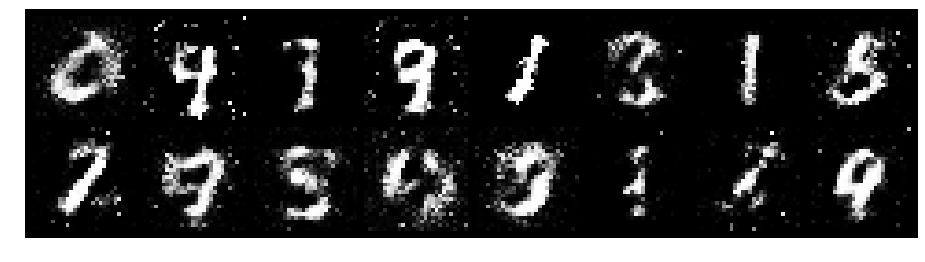

Epoch: [17/200], Batch Num: [0/600]
Discriminator Loss: 0.6262, Generator Loss: 2.0182
D(x): 0.7442, D(G(z)): 0.1802


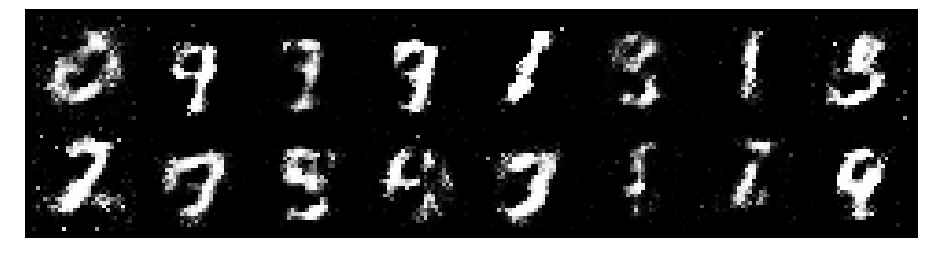

Epoch: [17/200], Batch Num: [100/600]
Discriminator Loss: 0.7526, Generator Loss: 2.0304
D(x): 0.8201, D(G(z)): 0.2796


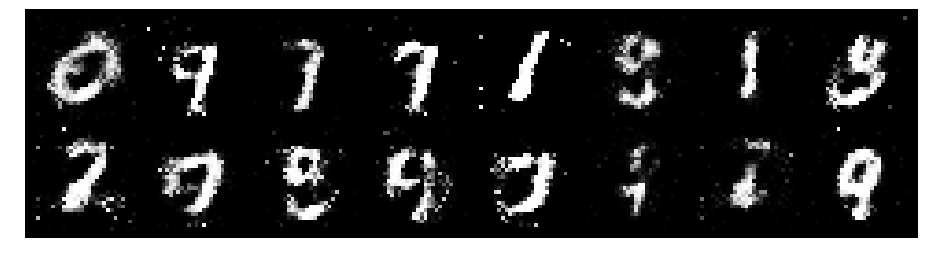

Epoch: [17/200], Batch Num: [200/600]
Discriminator Loss: 0.5573, Generator Loss: 1.8737
D(x): 0.7942, D(G(z)): 0.2065


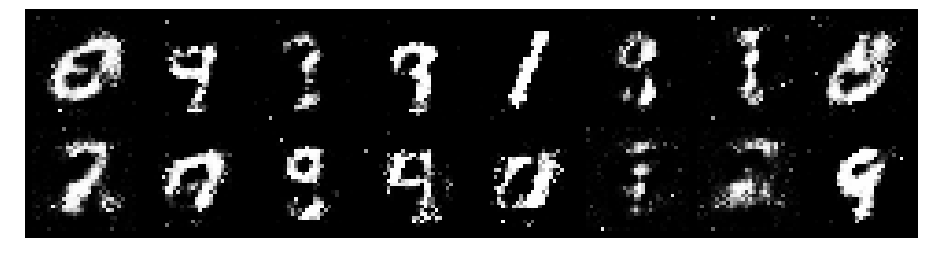

Epoch: [17/200], Batch Num: [300/600]
Discriminator Loss: 0.7182, Generator Loss: 1.8504
D(x): 0.7516, D(G(z)): 0.2315


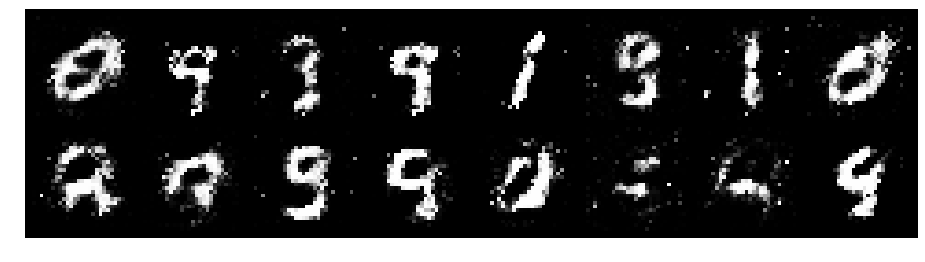

Epoch: [17/200], Batch Num: [400/600]
Discriminator Loss: 0.8046, Generator Loss: 1.4564
D(x): 0.6993, D(G(z)): 0.2594


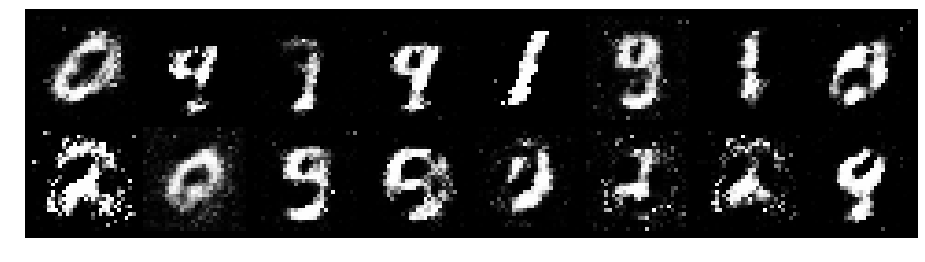

Epoch: [17/200], Batch Num: [500/600]
Discriminator Loss: 0.8700, Generator Loss: 2.1580
D(x): 0.7141, D(G(z)): 0.2593


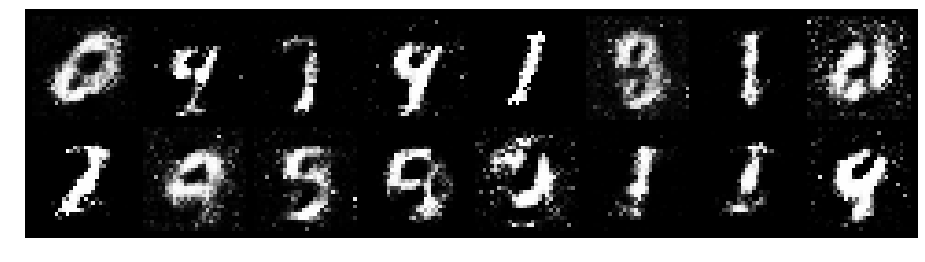

Epoch: [18/200], Batch Num: [0/600]
Discriminator Loss: 0.5128, Generator Loss: 2.4822
D(x): 0.8125, D(G(z)): 0.1772


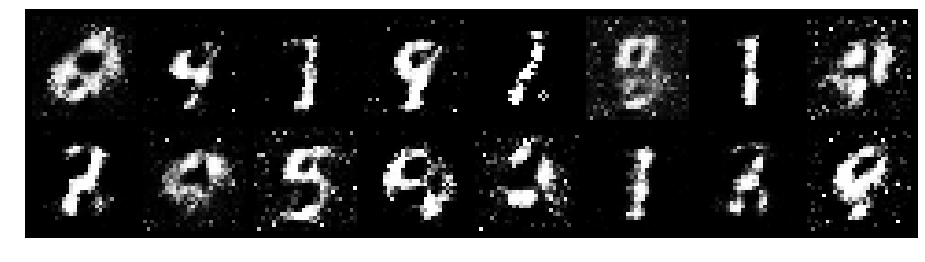

Epoch: [18/200], Batch Num: [100/600]
Discriminator Loss: 0.6831, Generator Loss: 2.4486
D(x): 0.7489, D(G(z)): 0.1807


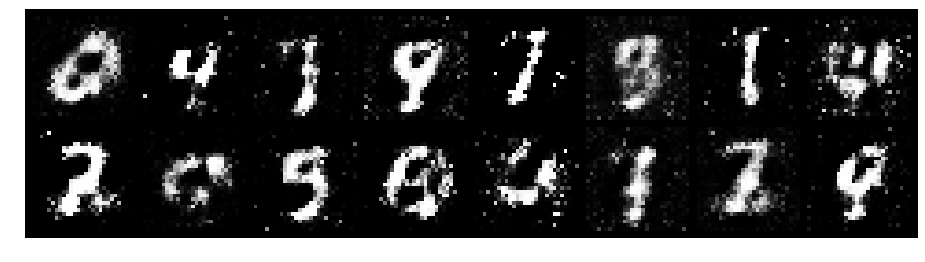

Epoch: [18/200], Batch Num: [200/600]
Discriminator Loss: 0.6744, Generator Loss: 2.1136
D(x): 0.7122, D(G(z)): 0.1707


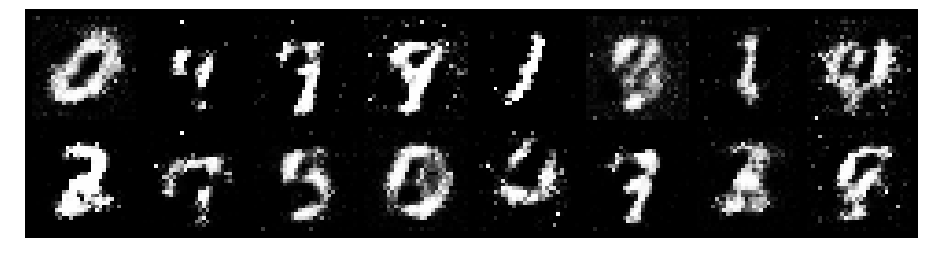

Epoch: [18/200], Batch Num: [300/600]
Discriminator Loss: 0.7087, Generator Loss: 2.2268
D(x): 0.7565, D(G(z)): 0.2012


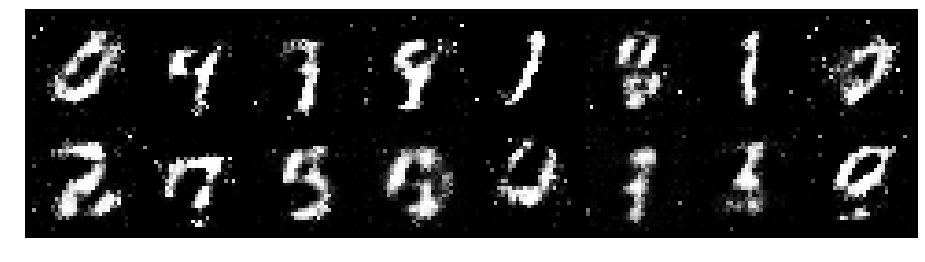

Epoch: [18/200], Batch Num: [400/600]
Discriminator Loss: 0.7504, Generator Loss: 2.3804
D(x): 0.7337, D(G(z)): 0.1876


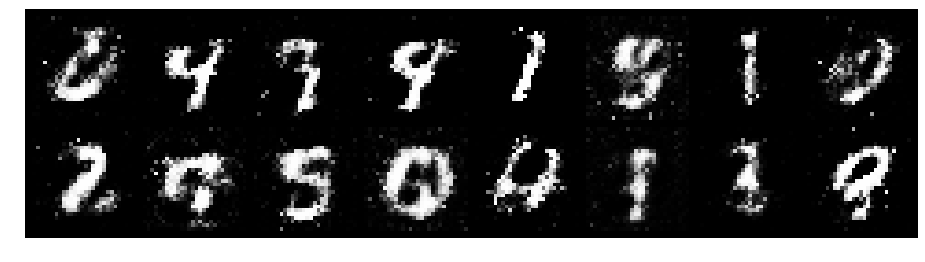

Epoch: [18/200], Batch Num: [500/600]
Discriminator Loss: 0.9940, Generator Loss: 1.6698
D(x): 0.7055, D(G(z)): 0.2977


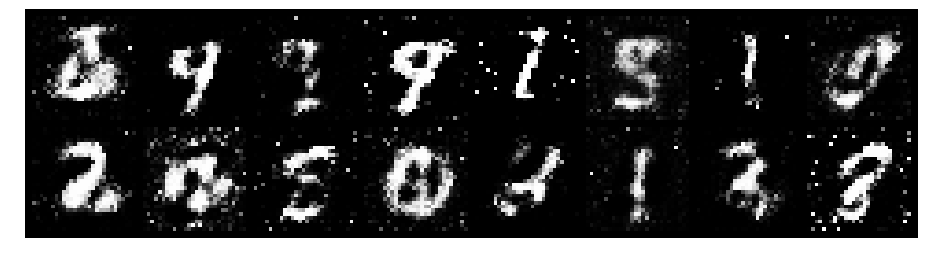

Epoch: [19/200], Batch Num: [0/600]
Discriminator Loss: 0.9899, Generator Loss: 1.5188
D(x): 0.6808, D(G(z)): 0.3186


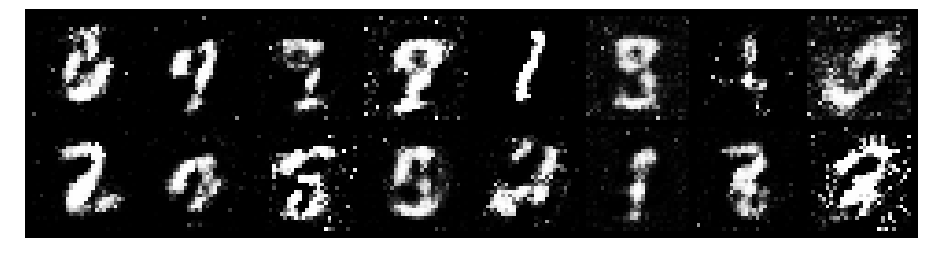

Epoch: [19/200], Batch Num: [100/600]
Discriminator Loss: 0.7439, Generator Loss: 1.7579
D(x): 0.7167, D(G(z)): 0.2419


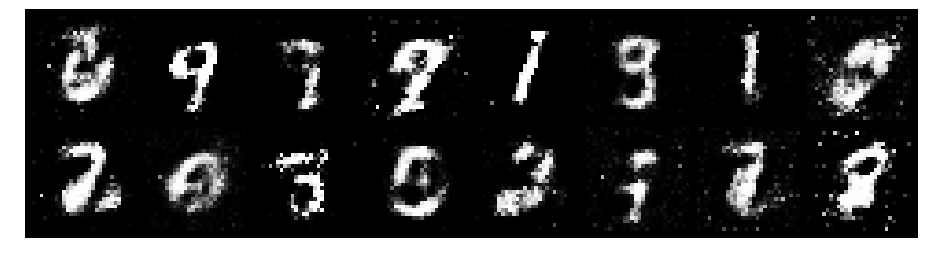

Epoch: [19/200], Batch Num: [200/600]
Discriminator Loss: 1.0510, Generator Loss: 1.4090
D(x): 0.6615, D(G(z)): 0.3410


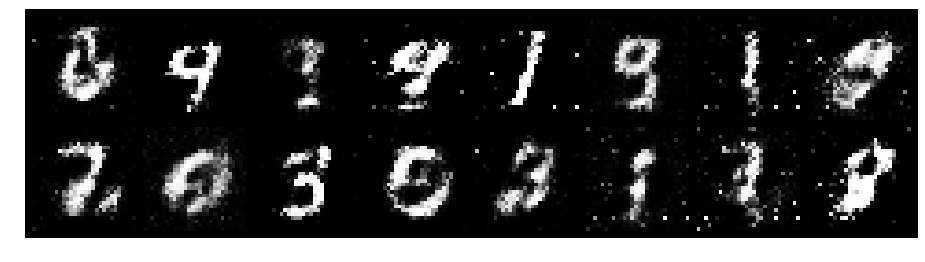

Epoch: [19/200], Batch Num: [300/600]
Discriminator Loss: 0.8732, Generator Loss: 1.5181
D(x): 0.7215, D(G(z)): 0.3225


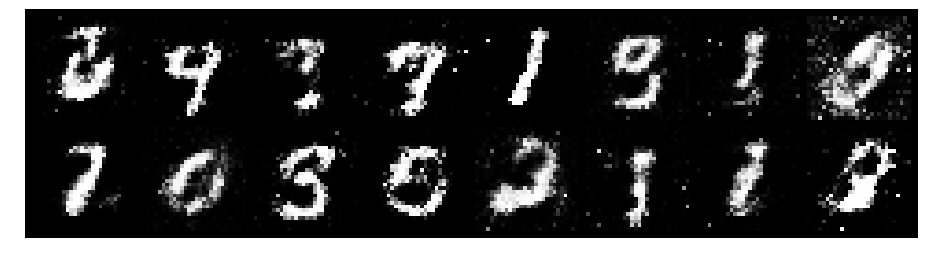

Epoch: [19/200], Batch Num: [400/600]
Discriminator Loss: 0.6789, Generator Loss: 1.8896
D(x): 0.7283, D(G(z)): 0.1870


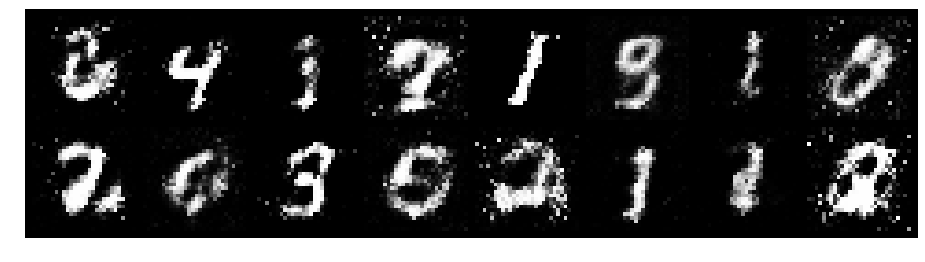

Epoch: [19/200], Batch Num: [500/600]
Discriminator Loss: 0.9431, Generator Loss: 1.4883
D(x): 0.6225, D(G(z)): 0.2018


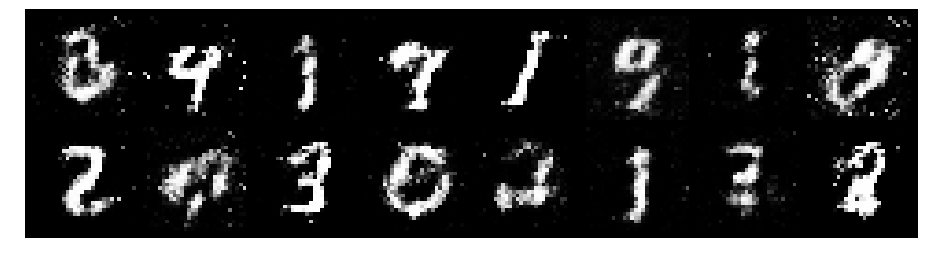

Epoch: [20/200], Batch Num: [0/600]
Discriminator Loss: 0.8429, Generator Loss: 1.8655
D(x): 0.6907, D(G(z)): 0.2636


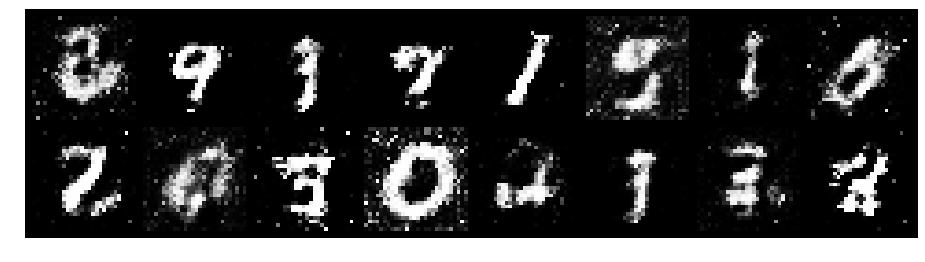

Epoch: [20/200], Batch Num: [100/600]
Discriminator Loss: 0.8640, Generator Loss: 2.0705
D(x): 0.7285, D(G(z)): 0.2938


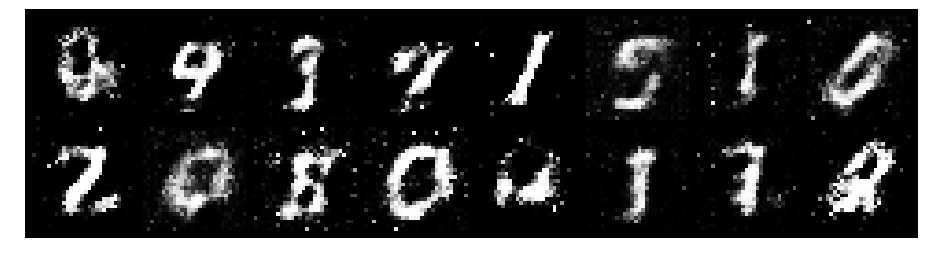

Epoch: [20/200], Batch Num: [200/600]
Discriminator Loss: 0.8508, Generator Loss: 1.4967
D(x): 0.7304, D(G(z)): 0.2936


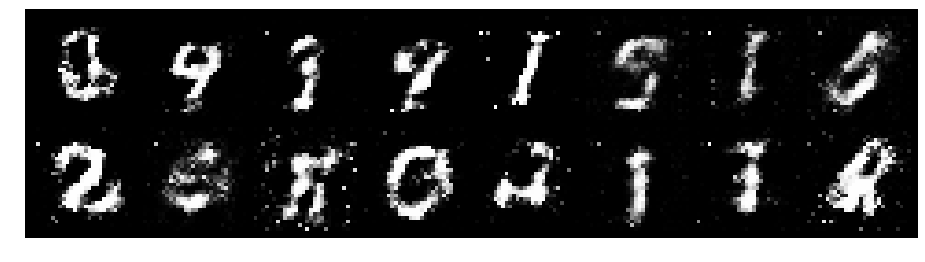

Epoch: [20/200], Batch Num: [300/600]
Discriminator Loss: 0.9446, Generator Loss: 1.3451
D(x): 0.7993, D(G(z)): 0.3966


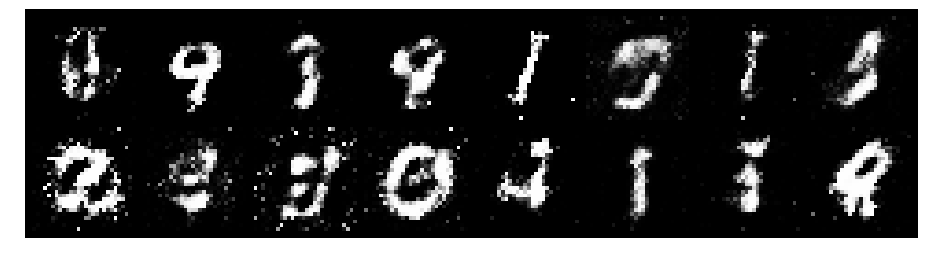

Epoch: [20/200], Batch Num: [400/600]
Discriminator Loss: 0.7456, Generator Loss: 1.9754
D(x): 0.7643, D(G(z)): 0.2663


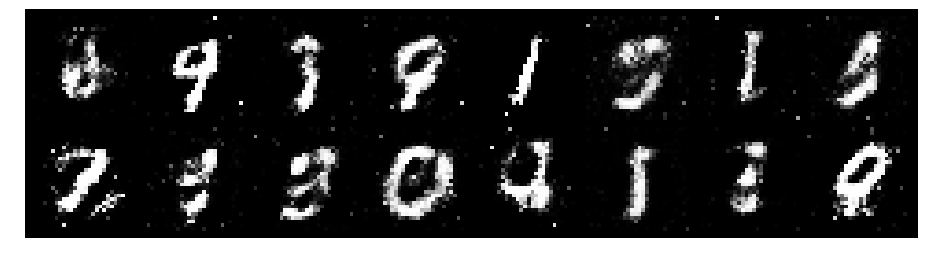

Epoch: [20/200], Batch Num: [500/600]
Discriminator Loss: 0.9101, Generator Loss: 1.5871
D(x): 0.7414, D(G(z)): 0.3088


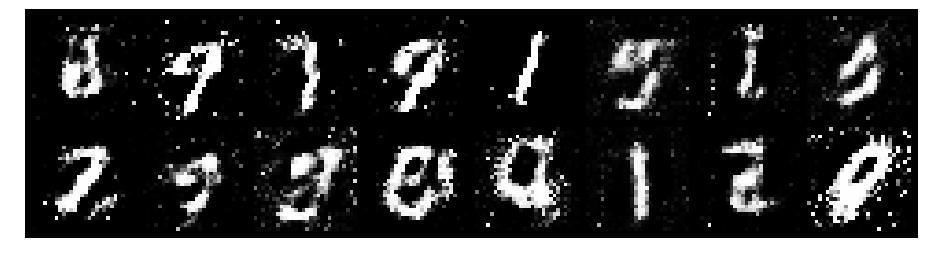

Epoch: [21/200], Batch Num: [0/600]
Discriminator Loss: 1.0581, Generator Loss: 1.7467
D(x): 0.6458, D(G(z)): 0.3141


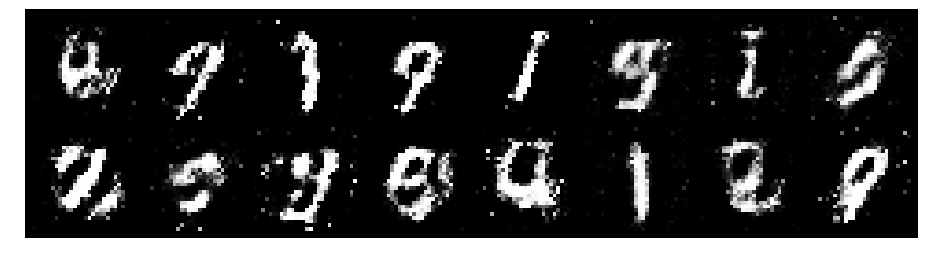

Epoch: [21/200], Batch Num: [100/600]
Discriminator Loss: 0.8096, Generator Loss: 2.4691
D(x): 0.7006, D(G(z)): 0.2165


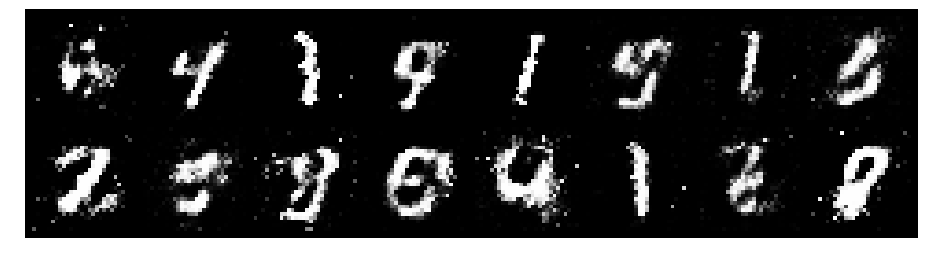

Epoch: [21/200], Batch Num: [200/600]
Discriminator Loss: 0.8880, Generator Loss: 1.6027
D(x): 0.6858, D(G(z)): 0.2460


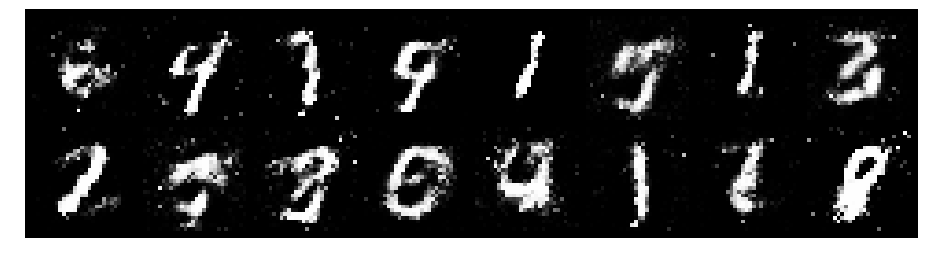

Epoch: [21/200], Batch Num: [300/600]
Discriminator Loss: 0.9267, Generator Loss: 1.5180
D(x): 0.6606, D(G(z)): 0.2835


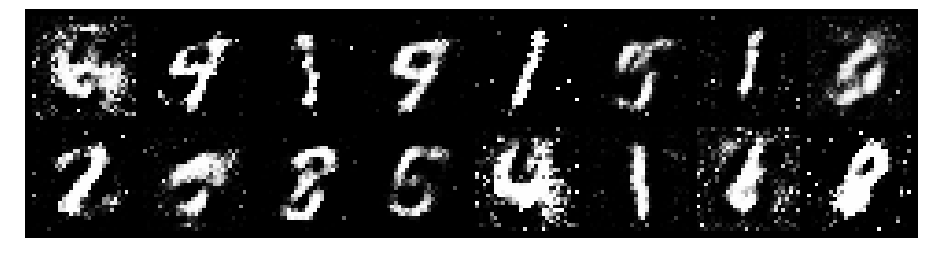

Epoch: [21/200], Batch Num: [400/600]
Discriminator Loss: 1.0072, Generator Loss: 1.4766
D(x): 0.6527, D(G(z)): 0.3014


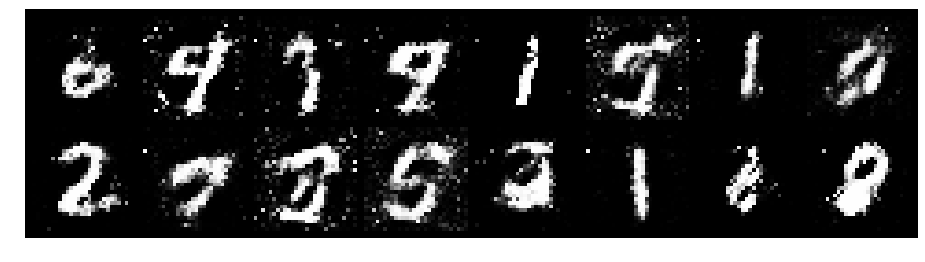

Epoch: [21/200], Batch Num: [500/600]
Discriminator Loss: 0.8886, Generator Loss: 2.2398
D(x): 0.6680, D(G(z)): 0.2593


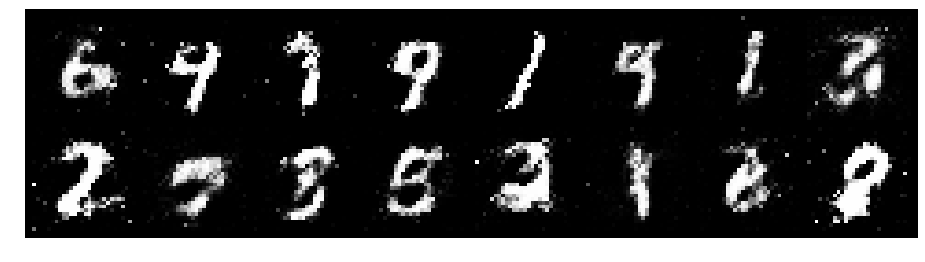

Epoch: [22/200], Batch Num: [0/600]
Discriminator Loss: 0.8097, Generator Loss: 1.9646
D(x): 0.7897, D(G(z)): 0.3195


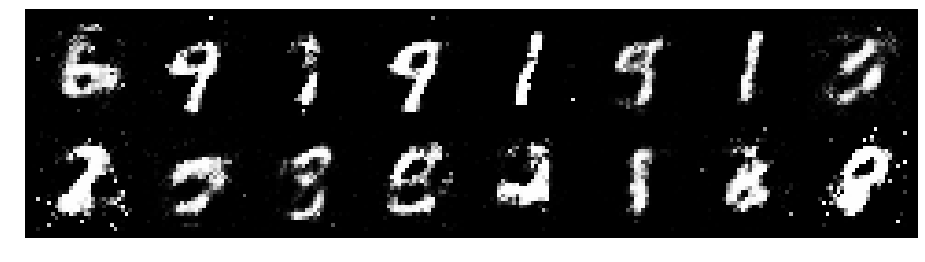

Epoch: [22/200], Batch Num: [100/600]
Discriminator Loss: 0.8061, Generator Loss: 1.6881
D(x): 0.7137, D(G(z)): 0.2557


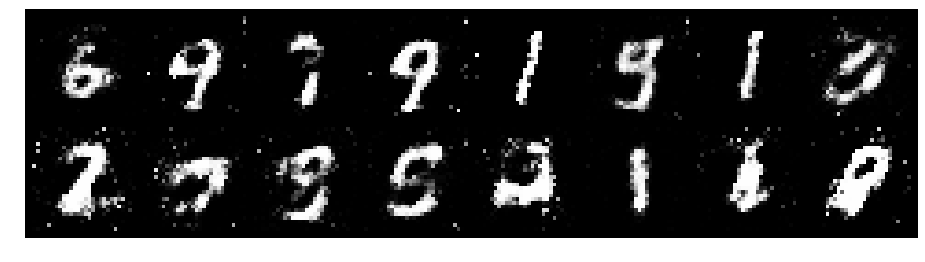

Epoch: [22/200], Batch Num: [200/600]
Discriminator Loss: 0.6480, Generator Loss: 1.6660
D(x): 0.7393, D(G(z)): 0.1953


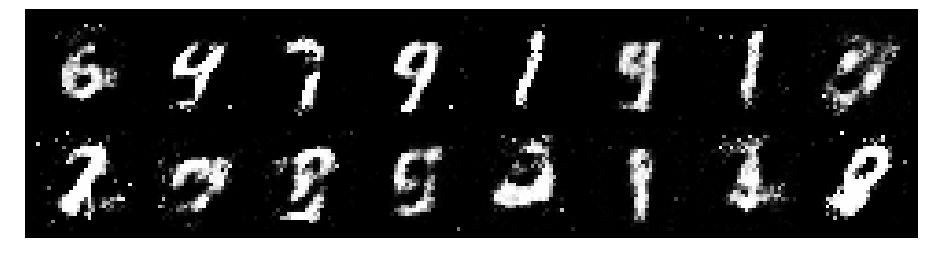

Epoch: [22/200], Batch Num: [300/600]
Discriminator Loss: 0.7936, Generator Loss: 2.0013
D(x): 0.8042, D(G(z)): 0.3267


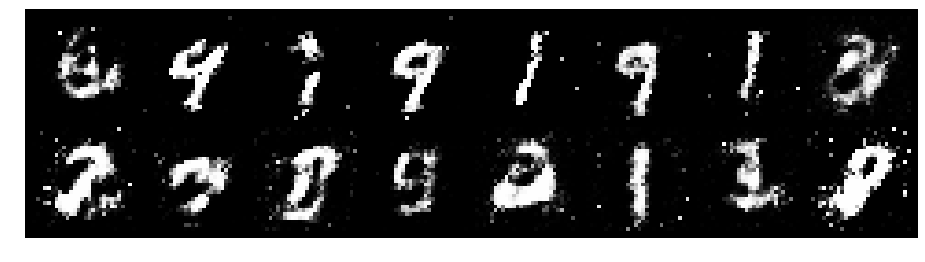

Epoch: [22/200], Batch Num: [400/600]
Discriminator Loss: 1.0400, Generator Loss: 1.6877
D(x): 0.6526, D(G(z)): 0.2858


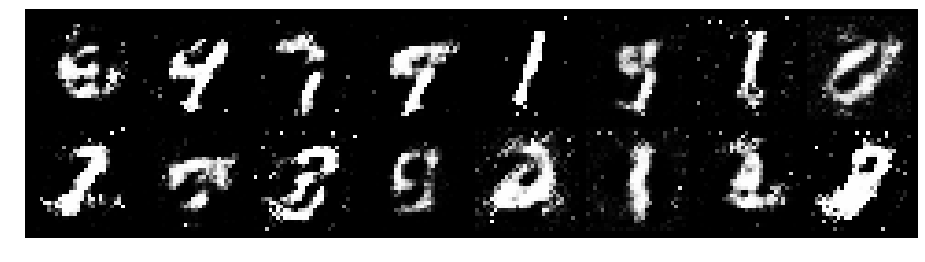

Epoch: [22/200], Batch Num: [500/600]
Discriminator Loss: 0.9007, Generator Loss: 1.7241
D(x): 0.7003, D(G(z)): 0.3085


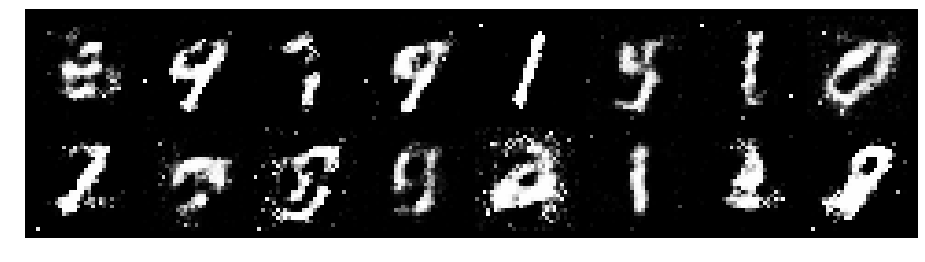

Epoch: [23/200], Batch Num: [0/600]
Discriminator Loss: 0.6750, Generator Loss: 1.9995
D(x): 0.7472, D(G(z)): 0.2031


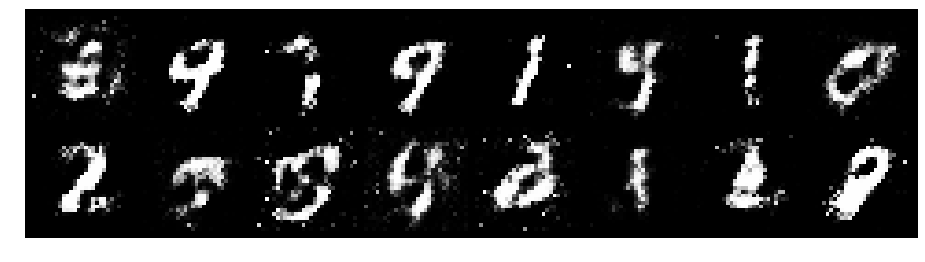

Epoch: [23/200], Batch Num: [100/600]
Discriminator Loss: 0.9868, Generator Loss: 1.8559
D(x): 0.7111, D(G(z)): 0.3232


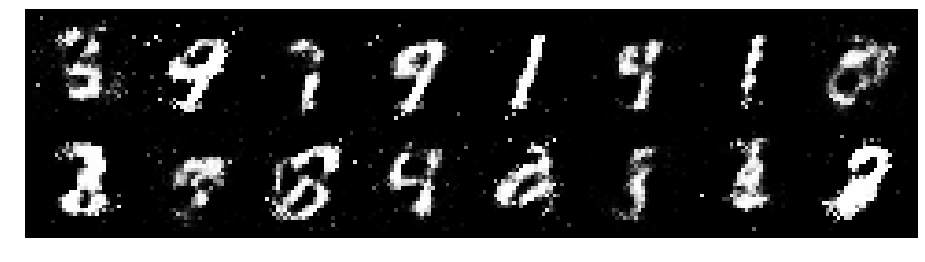

Epoch: [23/200], Batch Num: [200/600]
Discriminator Loss: 1.1090, Generator Loss: 1.5235
D(x): 0.6994, D(G(z)): 0.3865


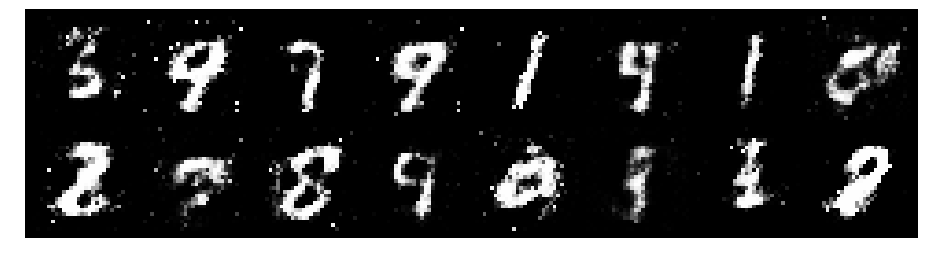

Epoch: [23/200], Batch Num: [300/600]
Discriminator Loss: 0.7895, Generator Loss: 1.8778
D(x): 0.6866, D(G(z)): 0.2346


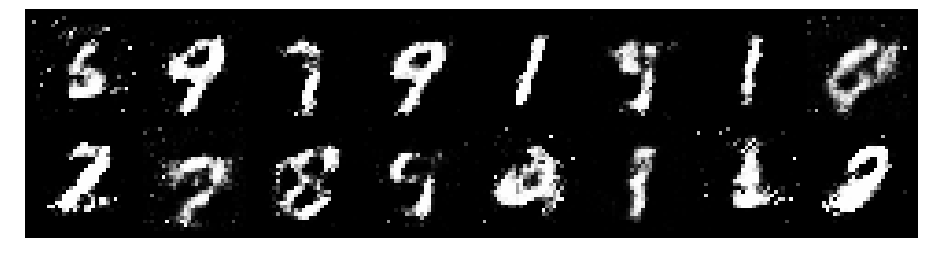

Epoch: [23/200], Batch Num: [400/600]
Discriminator Loss: 0.8316, Generator Loss: 1.6638
D(x): 0.7399, D(G(z)): 0.3035


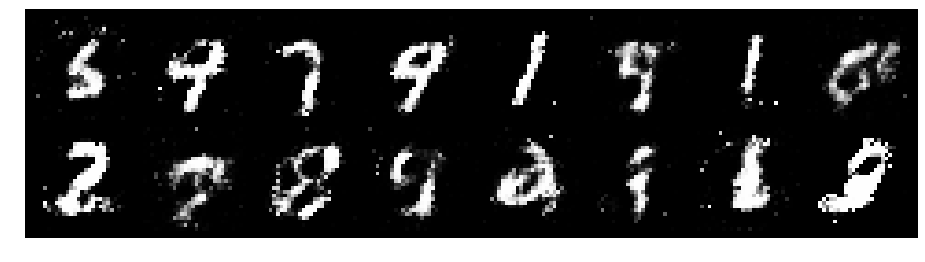

Epoch: [23/200], Batch Num: [500/600]
Discriminator Loss: 0.8539, Generator Loss: 1.5173
D(x): 0.7400, D(G(z)): 0.2981


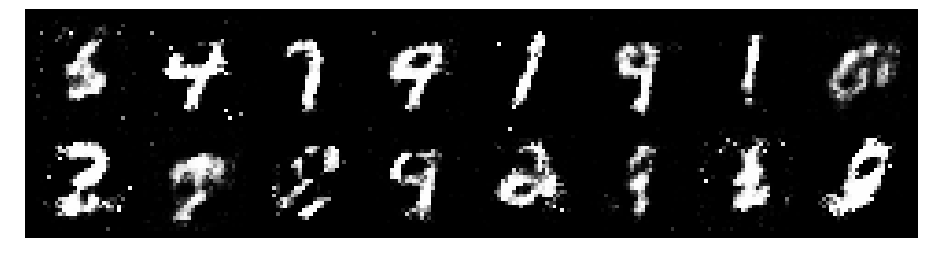

Epoch: [24/200], Batch Num: [0/600]
Discriminator Loss: 1.1840, Generator Loss: 1.5188
D(x): 0.6989, D(G(z)): 0.4070


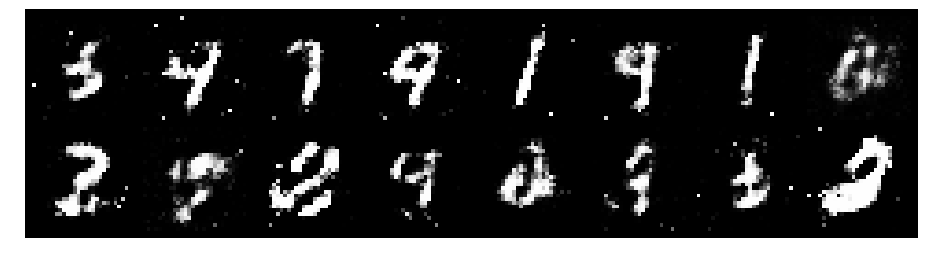

Epoch: [24/200], Batch Num: [100/600]
Discriminator Loss: 1.0159, Generator Loss: 1.5926
D(x): 0.6612, D(G(z)): 0.3316


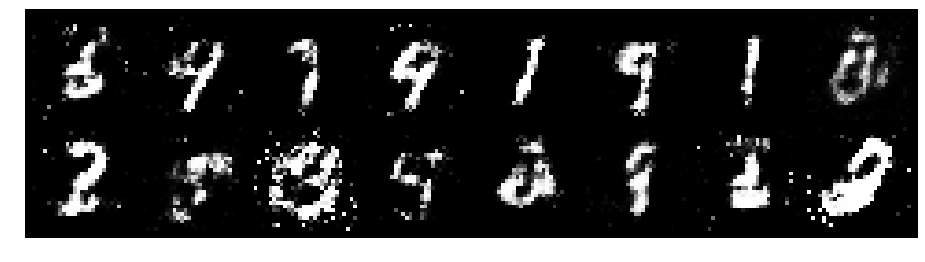

Epoch: [24/200], Batch Num: [200/600]
Discriminator Loss: 0.9144, Generator Loss: 1.6515
D(x): 0.7313, D(G(z)): 0.3258


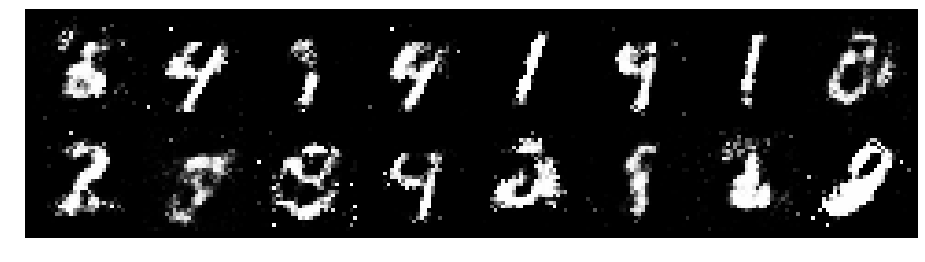

Epoch: [24/200], Batch Num: [300/600]
Discriminator Loss: 0.8865, Generator Loss: 1.7429
D(x): 0.6978, D(G(z)): 0.2915


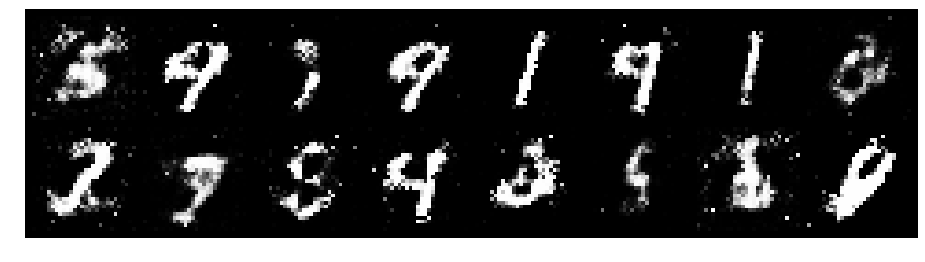

Epoch: [24/200], Batch Num: [400/600]
Discriminator Loss: 0.7455, Generator Loss: 1.4357
D(x): 0.7358, D(G(z)): 0.2833


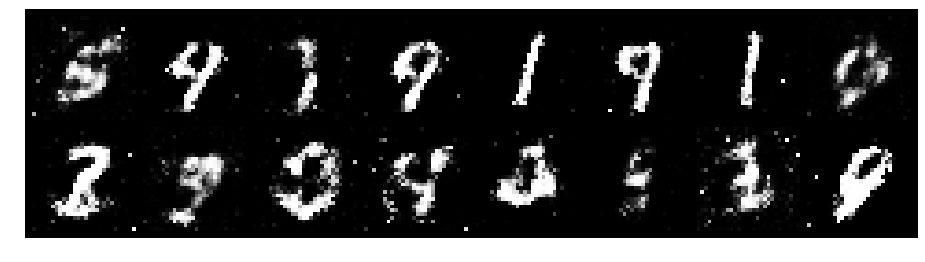

Epoch: [24/200], Batch Num: [500/600]
Discriminator Loss: 0.8032, Generator Loss: 1.4354
D(x): 0.7602, D(G(z)): 0.3169


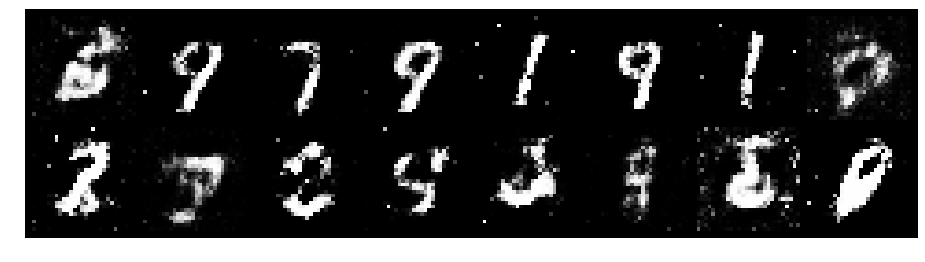

Epoch: [25/200], Batch Num: [0/600]
Discriminator Loss: 0.8413, Generator Loss: 1.7342
D(x): 0.6723, D(G(z)): 0.2527


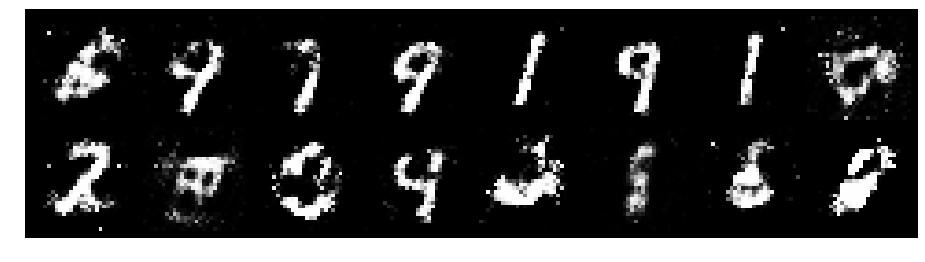

Epoch: [25/200], Batch Num: [100/600]
Discriminator Loss: 0.8208, Generator Loss: 1.6062
D(x): 0.7234, D(G(z)): 0.2919


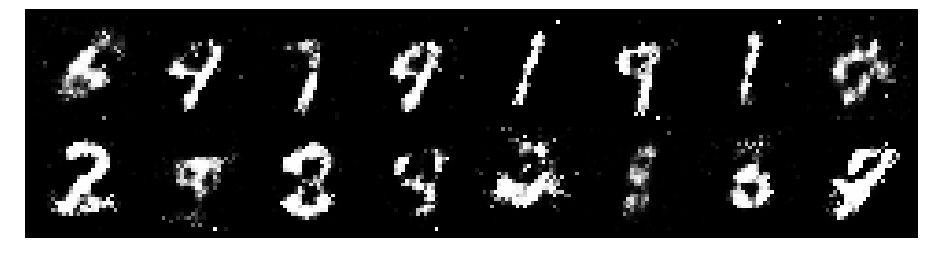

Epoch: [25/200], Batch Num: [200/600]
Discriminator Loss: 0.7539, Generator Loss: 1.6543
D(x): 0.7361, D(G(z)): 0.2682


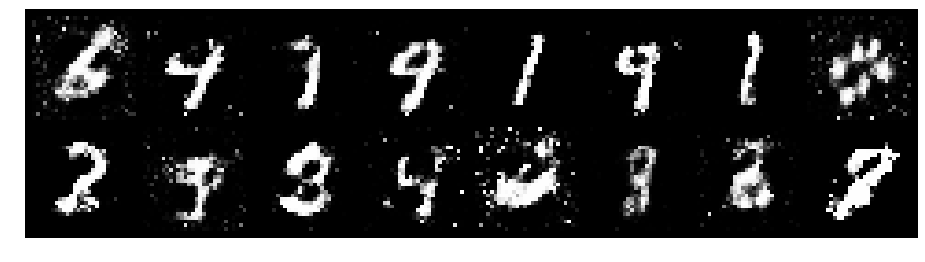

Epoch: [25/200], Batch Num: [300/600]
Discriminator Loss: 0.7338, Generator Loss: 1.5029
D(x): 0.7443, D(G(z)): 0.2641


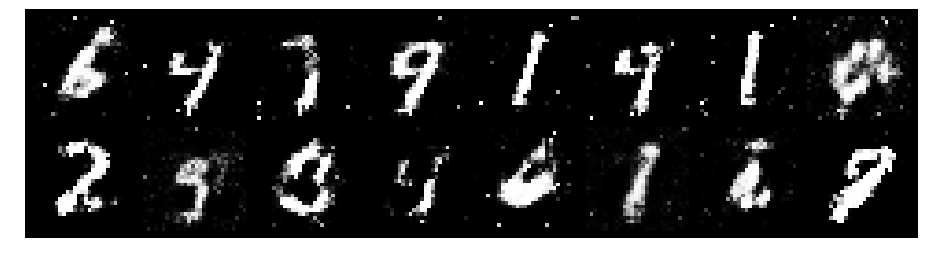

Epoch: [25/200], Batch Num: [400/600]
Discriminator Loss: 0.8197, Generator Loss: 1.6713
D(x): 0.7274, D(G(z)): 0.3083


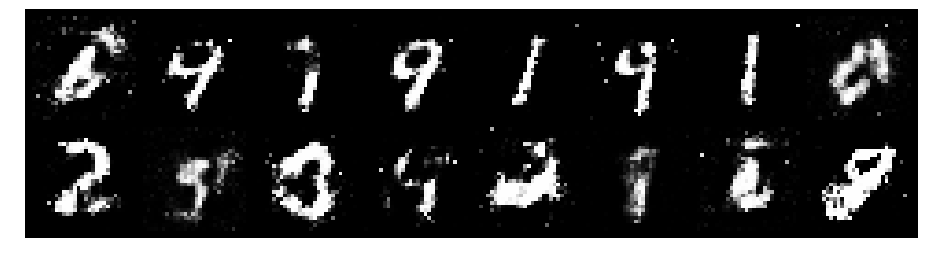

Epoch: [25/200], Batch Num: [500/600]
Discriminator Loss: 0.8037, Generator Loss: 1.5106
D(x): 0.7205, D(G(z)): 0.2966


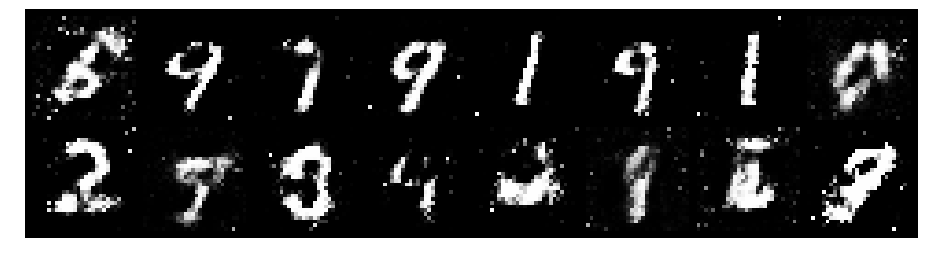

Epoch: [26/200], Batch Num: [0/600]
Discriminator Loss: 0.9226, Generator Loss: 1.5680
D(x): 0.6672, D(G(z)): 0.3145


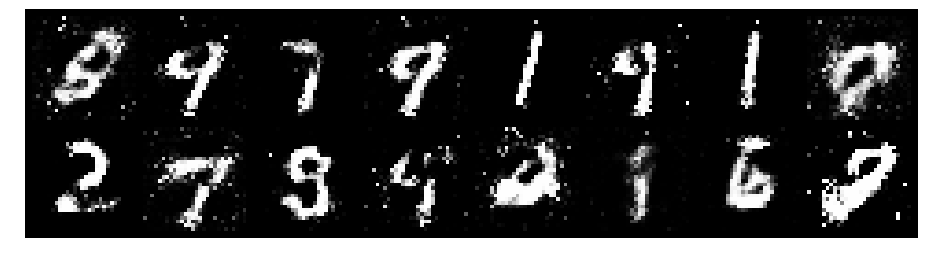

Epoch: [26/200], Batch Num: [100/600]
Discriminator Loss: 0.9027, Generator Loss: 1.6323
D(x): 0.6750, D(G(z)): 0.2788


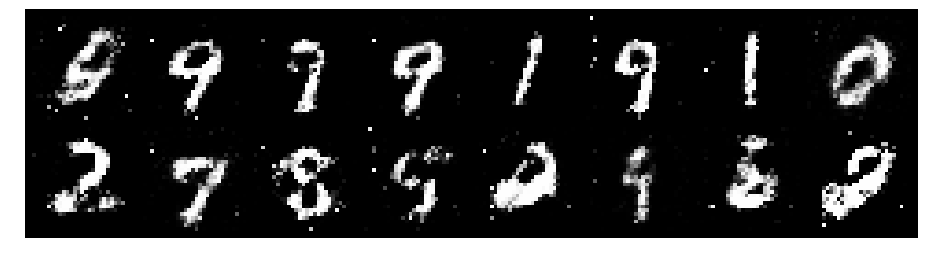

Epoch: [26/200], Batch Num: [200/600]
Discriminator Loss: 0.8271, Generator Loss: 1.7252
D(x): 0.6883, D(G(z)): 0.2347


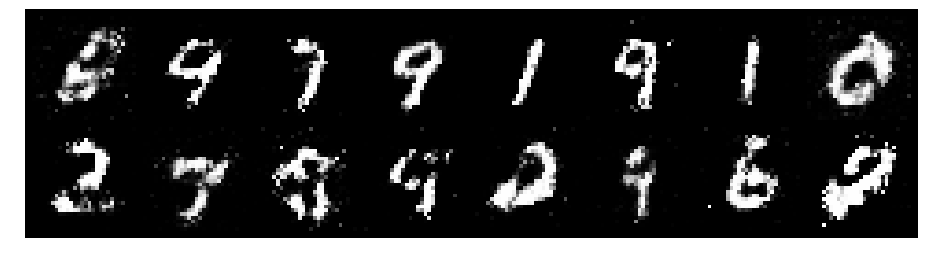

Epoch: [26/200], Batch Num: [300/600]
Discriminator Loss: 0.9451, Generator Loss: 1.5562
D(x): 0.6726, D(G(z)): 0.2719


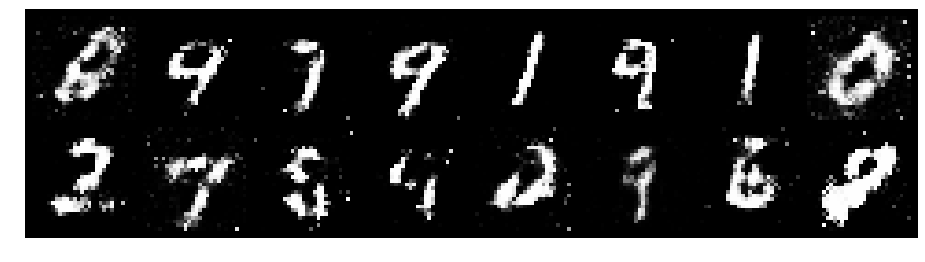

Epoch: [26/200], Batch Num: [400/600]
Discriminator Loss: 0.9940, Generator Loss: 1.4164
D(x): 0.6921, D(G(z)): 0.3655


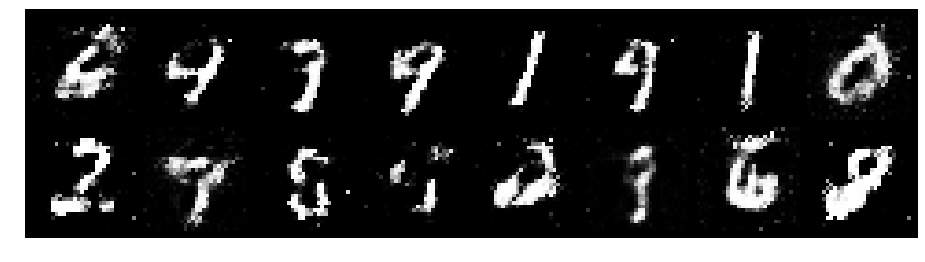

Epoch: [26/200], Batch Num: [500/600]
Discriminator Loss: 0.7768, Generator Loss: 1.4673
D(x): 0.7518, D(G(z)): 0.2986


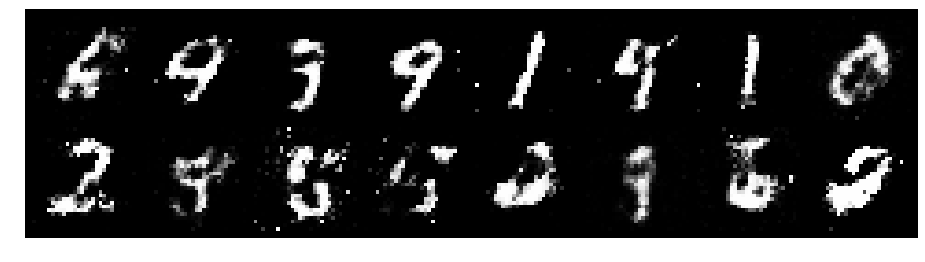

Epoch: [27/200], Batch Num: [0/600]
Discriminator Loss: 0.8666, Generator Loss: 1.8943
D(x): 0.6954, D(G(z)): 0.2629


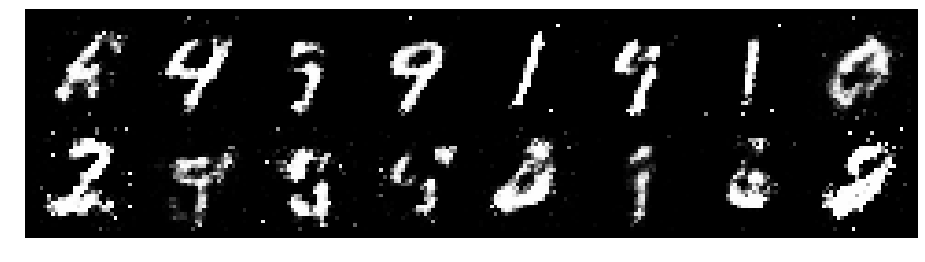

Epoch: [27/200], Batch Num: [100/600]
Discriminator Loss: 1.0190, Generator Loss: 1.1821
D(x): 0.6507, D(G(z)): 0.3033


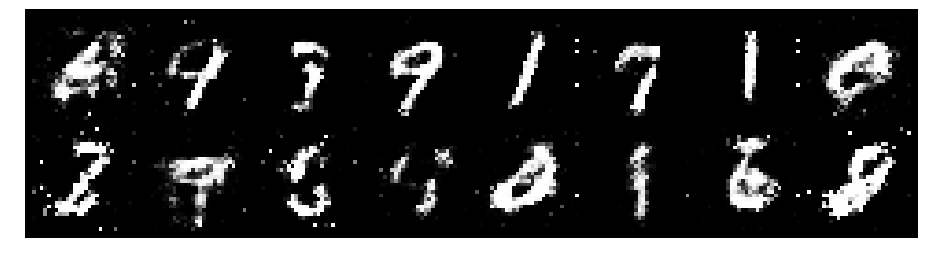

Epoch: [27/200], Batch Num: [200/600]
Discriminator Loss: 1.0415, Generator Loss: 1.2016
D(x): 0.6540, D(G(z)): 0.3642


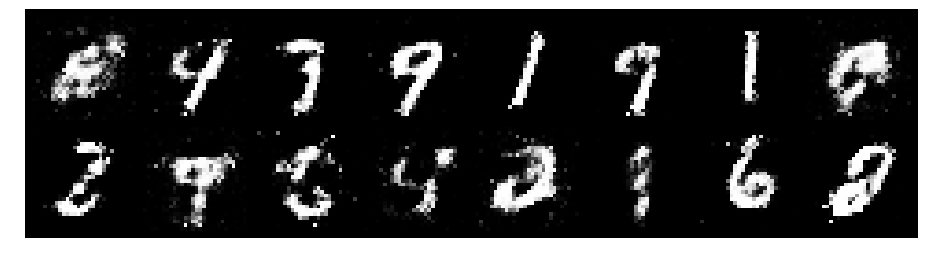

Epoch: [27/200], Batch Num: [300/600]
Discriminator Loss: 0.8832, Generator Loss: 1.4960
D(x): 0.7465, D(G(z)): 0.3462


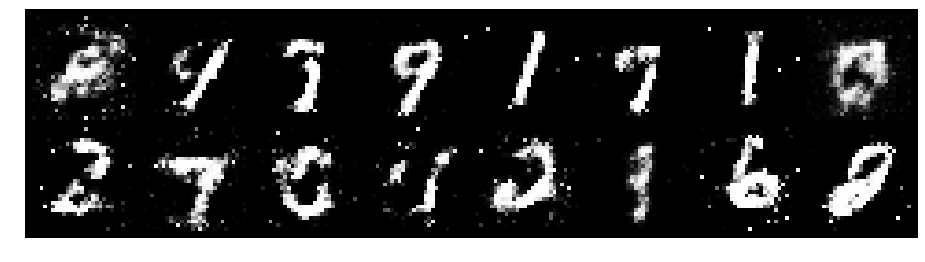

Epoch: [27/200], Batch Num: [400/600]
Discriminator Loss: 0.9334, Generator Loss: 1.1225
D(x): 0.7051, D(G(z)): 0.3645


In [0]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')

# Total number of epochs to train
num_epochs = 200

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)

        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))

        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()

        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator

        # Generate fake data
        fake_data = generator(noise(N))

        # Train G
        g_error = train_generator(g_optimizer, fake_data)

        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data

            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )